# TL;DR

The goal of this notebook is to visualize COVID-19 infections using data from https://github.com/CSSEGISandData/COVID-19.

Most illustrative plots of how the pandemic is being controlled:
- [Relative increases per day by country](#country_relative_increases)
- [Relative increases per day by state](#us_state_relative_increases)

Visualizations found in this notebook:
- [Top 20 countries by cumulative confirmed COVID-19 cases](#top_countries_confirmed)
- [Top 10 countries by NEW confirmed COVID-19 cases](#top_countries_confirmed_new)
- [Time-series plots of infections in most infected countries](#time-series_countries)
- [Forecasts of infections/deaths 1 and 7 days in the future](#forecasts_countries)
- [Relative increases per day by country](#country_relative_increases)
- [Time-series plots of mortality](#time-series_country_mortality)
- [Mortality as currently measured, compared to expected based on WHO mortality expectations](#counry_mortality_expectations)
  - [Source of expectations](http://weekly.chinacdc.cn/en/article/id/e53946e2-c6c4-41e9-9a9b-fea8db1a8f51)
- [Density of infections per million people](#density_of_infections_by_country)
- [How many days behind is each country from Italy?](#days_behind)
- [US states with the most new infections](#states_most_infections)
- [Time-series plots of infections in most-infected states](#time-series_states)
- [State forecasts of infections/deaths 1 and 7 days in the future](#forecast_us_state)
- [States and their daily increase fraction in confirmed cases/deaths](#us_state_daily_increase_fraction)
- [Compare US state infections against Washington](#state_infections_vs_wa)
- [Compare US state infections against New York](#state_infections_vs_ny)
- [Mortality rate by US state](#mortality_by_us_state)
- [Relative increases per day by state](#us_state_relative_increases)
- [When will each US state hit 1 case?](#us_state_0_new)

In [1]:


from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')



# Imports and definitions

In [2]:
import pandas as pd
import numpy as np
import os
import datetime
import re
from dateutil import parser
from matplotlib import pyplot as plt
import warnings

plt.rcParams['figure.figsize'] = 12,6
#plt.style.use('seaborn-dark-palette')
plt.style.use('seaborn-darkgrid')
pd.options.display.max_columns = 300

def datetime_to_unixtime(dt):
    return (dt - datetime.datetime(1970, 1, 1)).total_seconds()

# Load data

In [204]:
# define paths to each raw file
d_ts = {}
#d_ts['confirmed'] = '../COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv'
#d_ts['deaths'] = '../COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv'
d_ts['confirmed'] = '../COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
d_ts['deaths'] = '../COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'

#d_ts['recovered'] = '../COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv'

# load in each CSV
d_data = {}
for key, file_path in d_ts.items():
    d_data[key] = pd.read_csv(file_path)

# Clean to long form

In [205]:
def clean_wide_to_long(dfp, key):
    # find columns with dates in them
    cols = list(dfp.columns)
    date_cols = [col for col in cols if re.findall('(\d+/\d+/\d+)', col)]  #if '/' in col
    non_date_cols = list(set(cols) - set(date_cols))
    
    # wide to long
    dfp_melt = pd.melt(dfp, id_vars=non_date_cols, value_vars=date_cols)
    dfp_melt = dfp_melt.rename(columns={'variable': 'date', 
                                        'value': key,
                                        'Country/Region': 'country',
                                        'Province/State': 'state',
                                       })
    dfp_melt['date'] = dfp_melt['date'].apply(parser.parse)
    dfp_melt[key] = dfp_melt[key].apply(float)
    return dfp_melt

In [206]:
# convert from wide to long form
d_dfps = {}
dfp = None
merge_cols = ['country', 'state', 'date']
for key, dfp_wide in d_data.items():
    print(f'metric: {key} at {datetime.datetime.now()}')
    d_dfps[key] = clean_wide_to_long(dfp_wide, key)
    
    if dfp is None:
        dfp = d_dfps[key].copy()
    else:
        dfp_temp = d_dfps[key][merge_cols + [key]]
        dfp = dfp.merge(dfp_temp, on=merge_cols, how='left')
        
print(f"Latest data from {dfp['date'].max().strftime('%Y-%m-%d')}")

metric: confirmed at 2020-05-27 20:54:46.611660
metric: deaths at 2020-05-27 20:54:48.106621
Latest data from 2020-05-27


In [207]:
# aggregate by country (the US data is reported by state)
dfp_country = (dfp.groupby(['date', 'country'], as_index=False).
               agg({
                   'confirmed': np.sum,
                   'deaths': np.sum,
                   #'recovered': np.sum,
               }))
#dfp_country['active'] = dfp_country['confirmed'] - dfp_country['recovered']
dfp_country['confirmed_lag1'] = dfp_country.groupby(['country'])['confirmed'].shift(1)
dfp_country['confirmed_new'] = dfp_country['confirmed'] - dfp_country['confirmed_lag1']
dfp_country['deaths_lag1'] = dfp_country.groupby(['country'])['deaths'].shift(1)
dfp_country['deaths_new'] = dfp_country['deaths'] - dfp_country['deaths_lag1']
dfp_country['mortality_rate'] = dfp_country['deaths'] / dfp_country['confirmed']

<a id='top_countries_confirmed'></a>
##### Top 20 countries by cumulative confirmed COVID-19 cases

In [208]:
# get the top countries
id_cols = ['date', 'country']
value_cols = [
    'confirmed',
    'confirmed_new',
    'deaths',
    'deaths_new',
    #'active',
    'mortality_rate',
]
dfp_top_countries = dfp_country[dfp_country['date'] == dfp_country['date'].max()][id_cols + value_cols]
dfp_top_countries = dfp_top_countries.sort_values(by='deaths', ascending=0).reset_index(drop=True)
for key in value_cols:
    if 'rate' in key:
        continue
    dfp_top_countries[key] = dfp_top_countries[key].apply(int)
dfp_top_countries.head(20)

date         country  confirmed  confirmed_new  deaths  deaths_new  \
0  2020-05-27              US    1699176          18263  100418        1505   
1  2020-05-27  United Kingdom     268619           2020   37542         412   
2  2020-05-27           Italy     231139            584   33072         117   
3  2020-05-27          France     183038            191   28599          66   
4  2020-05-27           Spain     236259              0   27117           0   
5  2020-05-27          Brazil     411821          20599   25598        1086   
6  2020-05-27         Belgium      57592            137    9364          30   
7  2020-05-27          Mexico      78023           3463    8597         463   
8  2020-05-27         Germany     181524            324    8428          56   
9  2020-05-27            Iran     141591           2080    7564          56   
10 2020-05-27          Canada      88989            899    6876         123   
11 2020-05-27     Netherlands      45970            190    5890          15   
12 2020-05-27           China      84106              3    4638           0   
13 2020-05-27           India     158086           7293    4534         190   
14 2020-05-27          Turkey     159797           1035    4431          34   
15 2020-05-27          Sweden      35088            648    4220          95   
16 2020-05-27            Peru     135905           6154    3983         195   
17 2020-05-27          Russia     370680           8338    3968         161   
18 2020-05-27         Ecuador      38103            748    3275          72   
19 2020-05-27     Switzerland      30776             15    1917           2   

    mortality_rate  
0         0.059098  
1         0.139759  
2         0.143083  
3         0.156246  
4         0.114777  
5         0.062158  
6         0.162592  
7         0.110185  
8         0.046429  
9         0.053421  
10        0.077268  
11        0.128127  
12        0.055145  
13        0.028681  
14        0.027729  
15        0.120269  
16        0.029307  
17        0.010705  
18        0.085951  
19        0.062289

<a id='top_countries_confirmed_new'></a>
##### Top 10 countries by NEW confirmed COVID-19 cases

In [209]:
dfp_top_countries.sort_values(by='confirmed_new', ascending=0).head(10)

date         country  confirmed  confirmed_new  deaths  deaths_new  \
5  2020-05-27          Brazil     411821          20599   25598        1086   
0  2020-05-27              US    1699176          18263  100418        1505   
17 2020-05-27          Russia     370680           8338    3968         161   
13 2020-05-27           India     158086           7293    4534         190   
16 2020-05-27            Peru     135905           6154    3983         195   
28 2020-05-27           Chile      82289           4328     841          35   
7  2020-05-27          Mexico      78023           3463    8597         463   
9  2020-05-27            Iran     141591           2080    7564          56   
1  2020-05-27  United Kingdom     268619           2020   37542         412   
40 2020-05-27    Saudi Arabia      78541           1815     425          14   

    mortality_rate  
5         0.062158  
0         0.059098  
17        0.010705  
13        0.028681  
16        0.029307  
28        0.010220  
7         0.110185  
9         0.053421  
1         0.139759  
40        0.005411

<a id='time-series_countries'></a>
# Time-series plots of infections in most infected countries

In [210]:
def plot_countries(
    dfp_country,
    countries=dfp_top_countries.iloc[:10]['country'],
    plot_cols=['confirmed', 'deaths', 'recovered', 'active', 'confirmed_new'],
    country_col='country',
    n_columns=2,
    y_min=1,
    y_max=dfp_top_countries['confirmed'].max() * 1.5,
    date_col='date',
    y_label='num_cases',
    date_min=datetime.datetime(2020,2,1),
    is_log=True,
):
    i = 1
    n_rows = int(np.ceil(len(countries) / n_columns))
    plt.figure(figsize=(12,n_rows*5))
    
    for country in countries:
        dfp_plot = dfp_country[(dfp_country[country_col] == country) &
                               (dfp_country[date_col] >= date_min)
                              ]
        dfp_plot = dfp_plot[dfp_plot['confirmed_new'] != 0]
        plt.subplot(n_rows, n_columns, i)
        for key in plot_cols:
            plt.plot(dfp_plot[date_col], dfp_plot[key], alpha=0.7, label=key)
        plt.legend(loc='best')
        plt.ylabel(f'{y_label}')
        plt.title(f'{country_col}: {country}')
        if is_log:
            plt.yscale('log')
        plt.ylim([y_min, y_max])
        plt.xticks(rotation=90)

        i += 1
    plt.tight_layout()
    plt.show()

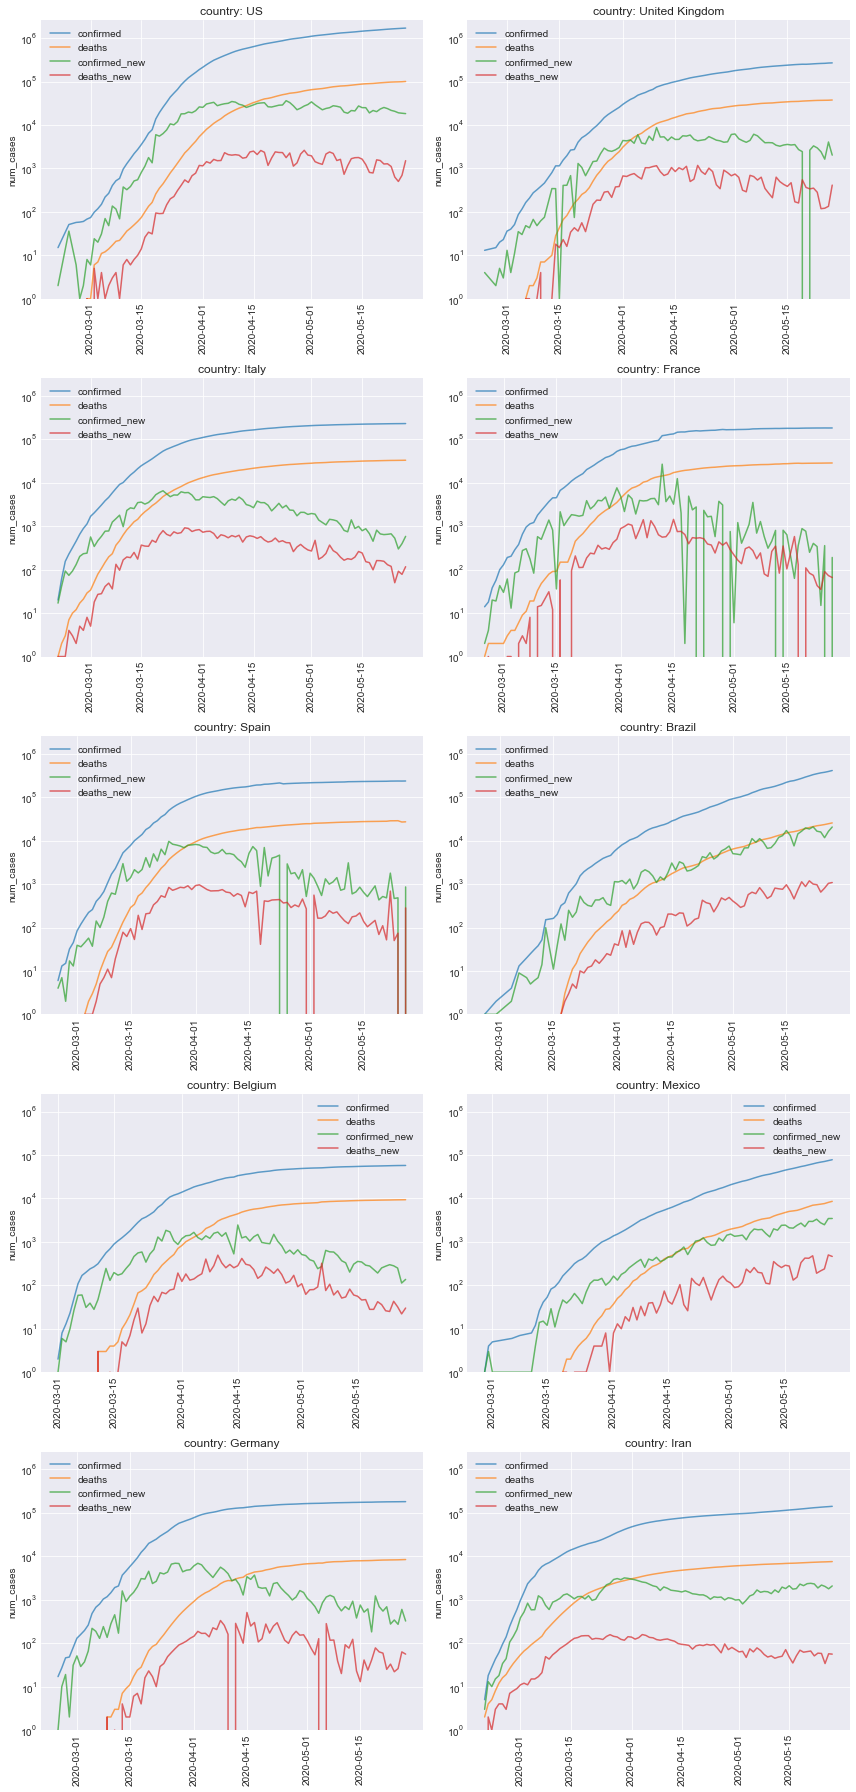

In [211]:
n_countries = 10

plot_countries(dfp_country, 
               countries=dfp_top_countries.iloc[:n_countries]['country'],
               plot_cols=['confirmed', 'deaths', 'confirmed_new', 'deaths_new'], #, 'recovered', 'active'
               country_col='country',
               date_min=datetime.datetime(2020,2,20),
              )

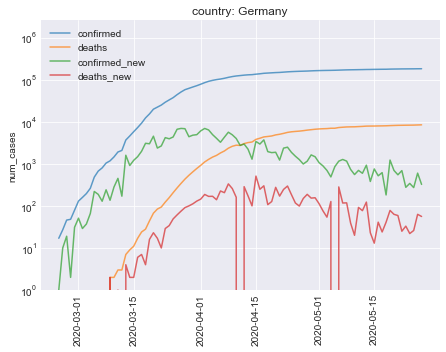

In [212]:
plot_countries(dfp_country, 
               countries=['Germany'],
               plot_cols=['confirmed', 'deaths', 'confirmed_new', 'deaths_new'], #, 'recovered', 'active'
               country_col='country',
               date_min=datetime.datetime(2020,2,20),
              )

<a id='forecasts_countries'></a>
# Forecasts of infections/deaths 1 and 7 days in the future

For confirmed cases (`confirmed_pred`) and deaths (`deaths_pred`)

In [213]:
def predict_from_fit(row):
    return int(10**(row['slope'] * row['unixtime'] + row['intercept']))

def shift_future(dfp, date_most_recent, days=1):
    dfp_most_recent = dfp.copy()
    dfp_most_recent['date'] = date_most_recent + datetime.timedelta(days=days)  #dfp_most_recent['date'] + datetime.timedelta(days=days)
    dfp_most_recent['unixtime'] = dfp_most_recent['date'].apply(datetime_to_unixtime)
    #dfp_most_recent['unixtime'] = dfp_most_recent['unixtime'] + 86400 * days
    
    for col in ['confirmed', 'deaths', 'recovered', 'active', 'confirmed_lag1', 'confirmed_new', 'deaths_new']:
        dfp_most_recent[col] = np.nan
    return dfp_most_recent

def fit_poly1(dfp_country_recent, 
              col_fit='confirmed_log', 
              col_pred='confirmed_pred', 
              date_most_recent=None,
              col_locale='country'
             ):
    warnings.simplefilter('ignore', np.RankWarning)
    if date_most_recent is None:
        date_most_recent = dfp_country_recent['date'].max()
    dfp_country_recent = dfp_country_recent.set_index(col_locale)
    
    # fit
    dfp_country_recent_clean = dfp_country_recent[(dfp_country_recent['date'] <= date_most_recent) &
                                                  (dfp_country_recent[col_fit] > 0)
                                                 ]
    dfp_country_confirmed_fit = (dfp_country_recent[dfp_country_recent['date'] <= date_most_recent].
                                 groupby([col_locale]).
                                 apply(lambda x: np.polyfit(x['unixtime'], x[col_fit], 1))
                                )
    dfp_country_recent['fits'] = dfp_country_confirmed_fit
    dfp_country_recent[['slope', 'intercept']] = dfp_country_recent['fits'].apply(pd.Series)   
    
    dfp_country_recent[col_pred] = dfp_country_recent.apply(predict_from_fit, axis=1)
    dfp_country_recent = dfp_country_recent.drop(columns=['fits', 'intercept']).reset_index() #'slope', 
    fit_col = col_fit.split('_')[0]
    dfp_country_recent[f"frac_increase_{fit_col}"] = (10**(dfp_country_recent['slope'] * 86400) - 1)
    #dfp_country_recent = dfp_country_recent.rename(columns={'slope': f'slope_{col_fit.split("_")[0]}'})
    return dfp_country_recent, dfp_country_confirmed_fit

def fit_exp(dfp_country, 
            n_days_predict=14, 
            n_days_into_future=[1,7],
            col_locale='country', 
            top_countries=None, 
            n_countries=10, 
            date_most_recent=None,
            is_silent=False
           ):
    # make predictions based on the last 2 weeks of data
    if date_most_recent is None:
        date_most_recent = dfp_country['date'].max()
    date_n_days_ago = date_most_recent - datetime.timedelta(days=n_days_predict-1)
    dfp_country_recent = (dfp_country[dfp_country['date'].between(date_n_days_ago, date_most_recent)].
                          sort_values(by=[col_locale, 'date'])
                         ).copy()

    # clean data for fit (convert to log)
    dfp_country_recent['confirmed_log'] = dfp_country_recent['confirmed'].apply(lambda x: np.log10(x) if x > 0 else 0)
    dfp_country_recent['deaths_log'] = dfp_country_recent['deaths'].apply(lambda x: np.log10(x) if x > 0 else 0)
    dfp_country_recent['unixtime'] = dfp_country_recent['date'].apply(datetime_to_unixtime)
    
    
    # make predictions to past, then future
    # add in future points
    dfp_country_recent_max_date = dfp_country_recent.groupby([col_locale], as_index=False).agg({'date': np.max})
    dfp_most_recent = dfp_country_recent.merge(dfp_country_recent_max_date, on=[col_locale, 'date'], how='inner').copy()
    #dfp_most_recent = dfp_country_recent[dfp_country_recent['date'] == date_most_recent].copy()
    list_dfp_recent = [dfp_country_recent]
    for n in n_days_into_future:
        dfp_most_recent_tmp = shift_future(dfp_most_recent, date_most_recent, n)
        list_dfp_recent.append(dfp_most_recent_tmp)
    #dfp_most_recent_7 = shift_future(dfp_most_recent, 7)
    #dfp_country_recent = pd.concat([dfp_country_recent, dfp_most_recent_1, dfp_most_recent_7], axis=0, sort=False)
    dfp_country_recent = pd.concat(list_dfp_recent, axis=0, sort=False)
    dfp_country_recent, dfp_country_deaths_fit = fit_poly1(dfp_country_recent, 
                                                           col_fit='deaths_log', 
                                                           col_pred='deaths_pred', 
                                                           col_locale=col_locale, 
                                                           date_most_recent=date_most_recent
                                                          )
    dfp_country_recent, dfp_country_confirmed_fit = fit_poly1(dfp_country_recent, 
                                                              col_fit='confirmed_log', 
                                                              col_pred='confirmed_pred', 
                                                              col_locale=col_locale, 
                                                              date_most_recent=date_most_recent
                                                             )
    dfp_country_recent['mortality_rate_pred'] = dfp_country_recent['deaths_pred'] / dfp_country_recent['confirmed_pred']

    # look only at the predictions for top countries
    if top_countries is None:
        top_countries = (dfp_most_recent.
                         sort_values(by='deaths', ascending=0).iloc[:n_countries][col_locale].values)
    dfp_forecasts = dfp_country_recent[(dfp_country_recent['date'] > date_most_recent)
                                       
                                      ].sort_values(by=[col_locale, 'date']).reset_index(drop=True)
    dfp_forecasts_out = dfp_forecasts[['date', 
                                       col_locale, 
                                       'confirmed_pred', 
                                       'deaths_pred', 
                                       'mortality_rate_pred', 
                                       'frac_increase_confirmed', 
                                       'frac_increase_deaths'
                                      ]].copy()
    dfp_forecasts_out['date'] = dfp_forecasts_out['date'].apply(lambda x: x.strftime('%Y-%m-%d'))

    # find the daily fractional increase in cases
    dfp_frac_increase = (dfp_forecasts_out.
                         groupby([col_locale]).
                         agg({'frac_increase_confirmed': np.mean, 
                              'frac_increase_deaths': np.mean}))
    dfp_frac_increase.columns = pd.MultiIndex.from_product([dfp_frac_increase.columns, ['']])

    # pivot so each date of prediction has its own column
    dfp_forecasts_print = dfp_forecasts_out.pivot(index=col_locale, 
                                                  columns='date', 
                                                  values=['confirmed_pred', 'deaths_pred', 'mortality_rate_pred']
                                                 ).sort_values(by=('deaths_pred', dfp_forecasts_out['date'].min()), ascending=0)
    dfp_forecasts_print = dfp_forecasts_print.merge(dfp_frac_increase, on=col_locale, how='inner')
    if not is_silent:
        display(dfp_forecasts_print[dfp_forecasts_print.index.isin(top_countries)])
    return dfp_country_recent, dfp_forecasts_out


def plot_forecasts(dfp_country_recent, 
                   n_countries=10, 
                   n_columns=2, 
                   figsize=(12,24), 
                   date_min=datetime.datetime(2020, 2, 1),
                   col_locale='country',
                  ):
    # subset the top countries
    dfp_non_pred = dfp_country_recent.dropna(subset=['deaths'])
    dt_max = dfp_non_pred['date'].max()
    dfp_top_countries = (dfp_non_pred[dfp_non_pred['date'] == dt_max].
                         sort_values(by='deaths', ascending=0).
                         iloc[:n_countries]
                        )
    top_countries = (dfp_top_countries.
                     iloc[:n_countries][col_locale].values
                    )

    # plot the top countries
    i = 1
    n_rows = int(np.ceil(n_countries / n_columns))
    plt.figure(figsize=figsize)
    y_max = dfp_country_recent['confirmed_pred'].max()
    y_min = max(dfp_country_recent['deaths'].min(), 1)

    for country in top_countries:
        dfp_plot = dfp_country_recent[(dfp_country_recent[col_locale] == country) &
                               (dfp_country_recent['date'] >= date_min)
                              ].sort_values(by='date')
        plt.subplot(n_rows, n_columns, i)
        for key in ['confirmed', 'deaths']:
            p = plt.plot(dfp_plot['date'], dfp_plot[key], alpha=0.5, linewidth=2, label=key)
            pred_col = f'{key}_pred'
            plt.plot(dfp_plot['date'], dfp_plot[pred_col], linestyle='--', linewidth=2, alpha=0.5, color=p[0].get_color(), label=pred_col)
        plt.legend(loc='best')
        plt.ylabel('num cases')
        plt.title(f'{col_locale}: {country}')
        plt.yscale('log')
        plt.ylim([y_min, y_max])
        plt.xticks(rotation=90)

        i += 1
    plt.tight_layout()
    plt.show()
    return None
                       
                       
def save_forecast(dfp_forecasts_out, dfp_country_recent, n_days_training=14):
    date_most_recent = dfp_country_recent.dropna(subset=['deaths'])['date'].max()
    dfp_forecasts_out['date_of_forecast'] = date_most_recent
    save_name = f"covid-19_country_forecast_from_{date_most_recent.strftime('%Y-%m-%d')}_n_days_training={n_days_training}.csv"
    save_path = os.path.join('predictions', save_name)
    dfp_forecasts_out.to_csv(save_path, index=False)
    print(f'saved forecast to {save_path}')
    return None

##### Forecasts based on last 1 week

confirmed_pred                       deaths_pred             \
date               2020-05-28 2020-06-03 2020-06-17  2020-05-28 2020-06-03   
country                                                                      
US                  1723337.0  1855664.0  2205298.0    101074.0   106583.0   
United Kingdom       271637.0   288984.0   333891.0     37679.0    38973.0   
Italy                231682.0   234734.0   242014.0     33159.0    33722.0   
France               183326.0   184323.0   186671.0     28651.0    29032.0   
Spain                237077.0   239828.0   246373.0     26822.0    25343.0   
Brazil               431013.0   564899.0  1061918.0     26564.0    33642.0   
Belgium               57939.0    59371.0    62853.0      9397.0     9584.0   
Mexico                81566.0   106355.0   197550.0      8856.0    11451.0   
Germany              181929.0   184346.0   190110.0      8442.0     8665.0   
Iran                 143864.0   157359.0   193978.0      7616.0     7943.0   

                          mortality_rate_pred                        \
date           2020-06-17          2020-05-28 2020-06-03 2020-06-17   
country                                                               
US               120632.0            0.058650   0.057437   0.054701   
United Kingdom    42168.0            0.138711   0.134862   0.126293   
Italy             35075.0            0.143123   0.143660   0.144930   
France            29940.0            0.156284   0.157506   0.160389   
Spain             22203.0            0.113136   0.105672   0.090119   
Brazil            58375.0            0.061632   0.059554   0.054971   
Belgium           10035.0            0.162188   0.161426   0.159658   
Mexico            20855.0            0.108575   0.107668   0.105568   
Germany            9209.0            0.046403   0.047004   0.048440   
Iran               8762.0            0.052939   0.050477   0.045170   

               frac_increase_confirmed frac_increase_deaths  
date                                                         
country                                                      
US                            0.012406             0.008884  
United Kingdom                0.010371             0.005644  
Italy                         0.002184             0.002813  
France                        0.000904             0.002202  
Spain                         0.001925            -0.009406  
Brazil                        0.046116             0.040151  
Belgium                       0.004079             0.003290  
Mexico                        0.045221             0.043750  
Germany                       0.002201             0.004355  
Iran                          0.015056             0.007033

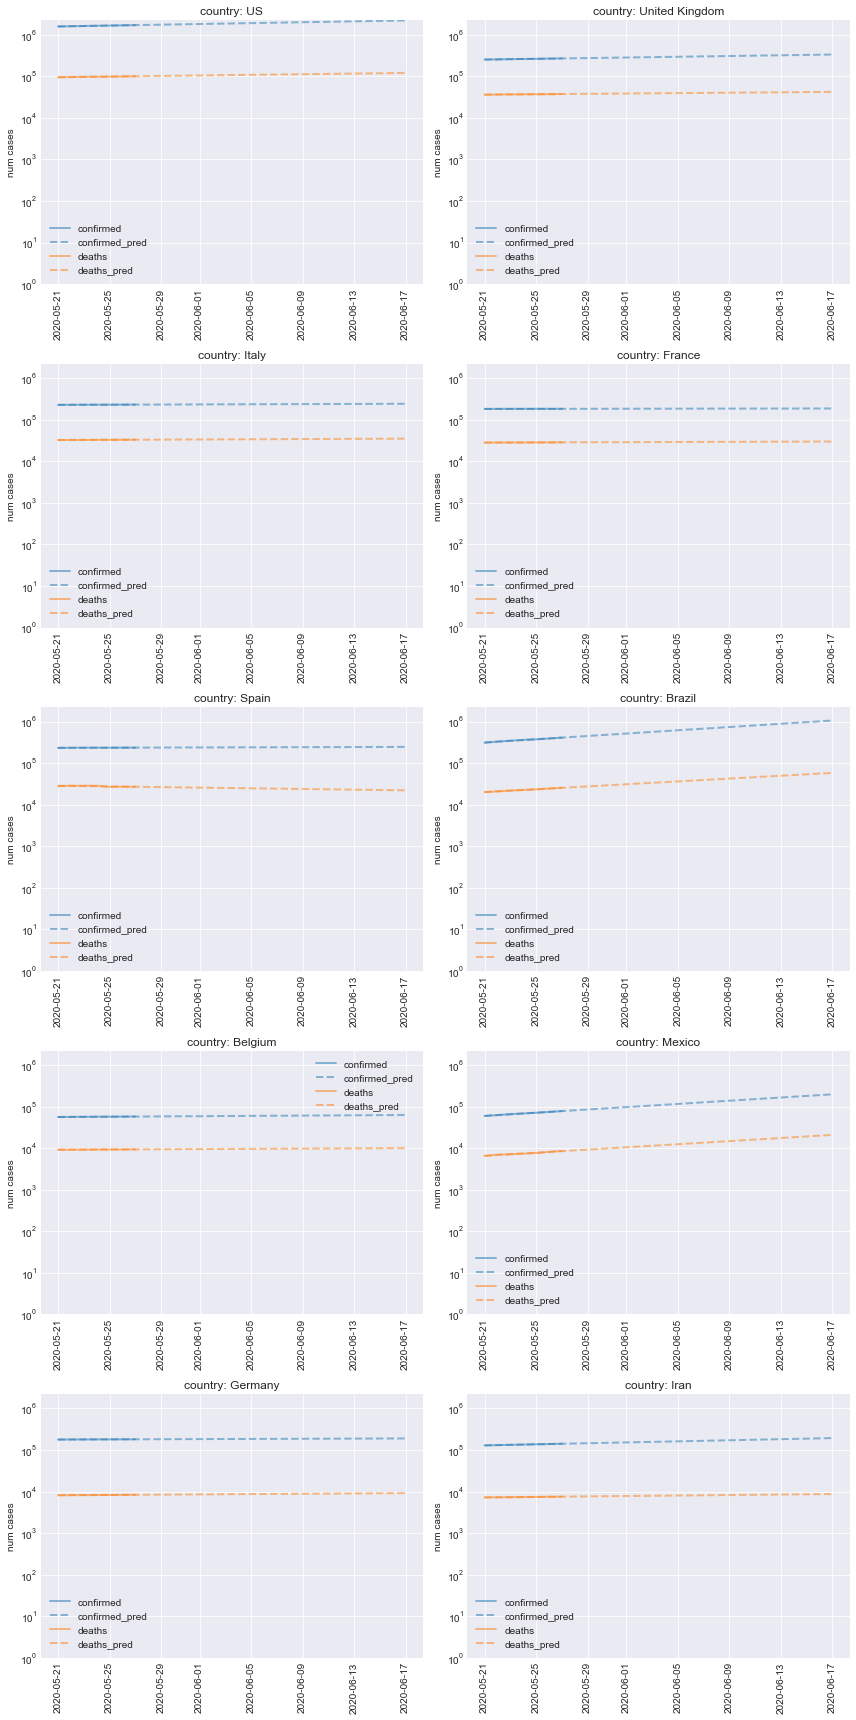

In [214]:
dfp_country_recent_1, dfp_forecasts_out_1 = fit_exp(dfp_country, 
                                                    n_days_predict=7,
                                                    n_days_into_future=[1,7,21], 
                                                    col_locale='country', 
                                                    top_countries=None
                                                   )
plot_forecasts(dfp_country_recent_1)

In [215]:
save_forecast(dfp_forecasts_out_1, dfp_country_recent_1, 7)

saved forecast to predictions/covid-19_country_forecast_from_2020-05-27_n_days_training=7.csv


<a id='country_relative_increases'></a>
### Relative increases per day by country

In [216]:
def find_relative_increase_data_and_plot(dfp_us_g, 
                                         n_days_fit=7, 
                                         dt=datetime.datetime(2020,3,10),
                                         n_locales=7,
                                         col_locale='state'
                                        ):
    dt_max = dfp_us_g['date'].max()
    list_dfp_state_relative = []
    while dt <= dt_max:
        try:
            dfp_state_recent_tmp, dfp_state_forecasts_out_tmp = fit_exp(dfp_us_g, 
                                                                        n_days_predict=n_days_fit, 
                                                                        col_locale=col_locale, 
                                                                        top_countries=None,
                                                                        date_most_recent=dt,
                                                                        is_silent=True
                                                                       )
            dfp_state_recent_tmp = dfp_state_recent_tmp.dropna(subset=['confirmed'])
            dfp_state_recent_tmp_single = dfp_state_recent_tmp[dfp_state_recent_tmp['date'] == dfp_state_recent_tmp['date'].max()]
            list_dfp_state_relative.append(dfp_state_recent_tmp_single)
        except Exception as e:
            print(f"failed on {dt.strftime('%Y-%m-%d')}")

        dt += datetime.timedelta(days=1)
    dfp_state_relative_chng = pd.concat(list_dfp_state_relative)
                  
    # plot states
    top_states = (dfp_state_relative_chng[(dfp_state_relative_chng['date'] == dfp_state_relative_chng['date'].max())].
                  sort_values(by='deaths', ascending=0).
                  reset_index(drop=True).
                  iloc[:n_locales][col_locale].values
                 )
                  
    # deaths
    plt.subplot(1,2,1)
    for state in top_states:
        dfp_st = dfp_state_relative_chng[(dfp_state_relative_chng[col_locale] == state) & 
                                         (dfp_state_relative_chng['deaths'] > 2)]
        #
        plt.plot(dfp_st['date'], dfp_st['frac_increase_deaths'], label=state, alpha=0.7)
        plt.ylabel('relative increase in deaths')
        plt.xticks(rotation=90)
        plt.legend(loc='best')
        plt.axhline(0, color='k', alpha=0.5)
        plt.title('Relative daily increase in deaths')

    # confirmed cases
    plt.subplot(1,2,2)
    for state in top_states:
        dfp_st = dfp_state_relative_chng[(dfp_state_relative_chng[col_locale] == state) & 
                                         (dfp_state_relative_chng['deaths'] > 2)]
        
        plt.plot(dfp_st['date'], dfp_st['frac_increase_confirmed'], label=state, alpha=0.7)
        plt.ylabel('relative increase in confirmed')
        plt.xticks(rotation=90)
        plt.legend(loc='best')
        plt.axhline(0, color='k', alpha=0.5)
        plt.title('Relative daily increase in confirmed')

    plt.show()
    return None


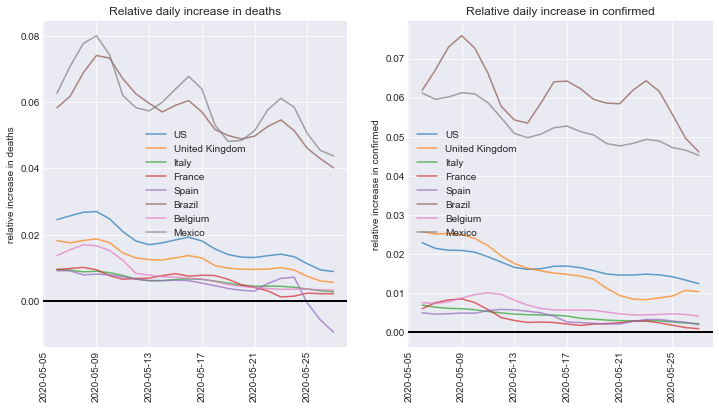

In [217]:
now = datetime.datetime.now()
now = datetime.datetime(now.year, now.month, now.day)
n_days_back = 21
dt_start = now - datetime.timedelta(days=n_days_back)
#dt_start = datetime.datetime(2020,3,2)
find_relative_increase_data_and_plot(dfp_country, n_locales=8, col_locale='country', dt=dt_start)

##### Forecasts based on last 2 weeks

confirmed_pred            deaths_pred             \
date               2020-05-28 2020-06-03  2020-05-28 2020-06-03   
country                                                           
US                  1734050.0  1886111.0    102202.0   109746.0   
United Kingdom       271439.0   288031.0     38046.0    39974.0   
Italy                232160.0   235978.0     33306.0    34108.0   
France               183993.0   186117.0     28758.0    29273.0   
Spain                237456.0   240965.0     27771.0    27801.0   
Brazil               445844.0   618500.0     27243.0    36018.0   
Belgium               58056.0    59668.0      9416.0     9630.0   
Mexico                82218.0   108634.0      9064.0    12238.0   
Germany              182552.0   185990.0      8471.0     8745.0   
Iran                 144712.0   159867.0      7638.0     8005.0   

               mortality_rate_pred            frac_increase_confirmed  \
date                    2020-05-28 2020-06-03                           
country                                                                 
US                        0.058938   0.058186                0.014108   
United Kingdom            0.140164   0.138784                0.009938   
Italy                     0.143461   0.144539                0.002723   
France                    0.156299   0.157283                0.001915   
Spain                     0.116952   0.115374                0.002448   
Brazil                    0.061104   0.058234                0.056070   
Belgium                   0.162188   0.161393                0.004575   
Mexico                    0.110243   0.112653                0.047530   
Germany                   0.046403   0.047019                0.003115   
Iran                      0.052781   0.050073                0.016737   

               frac_increase_deaths  
date                                 
country                              
US                         0.011939  
United Kingdom             0.008273  
Italy                      0.003974  
France                     0.002964  
Spain                      0.000183  
Brazil                     0.047633  
Belgium                    0.003758  
Mexico                     0.051306  
Germany                    0.005328  
Iran                       0.007858

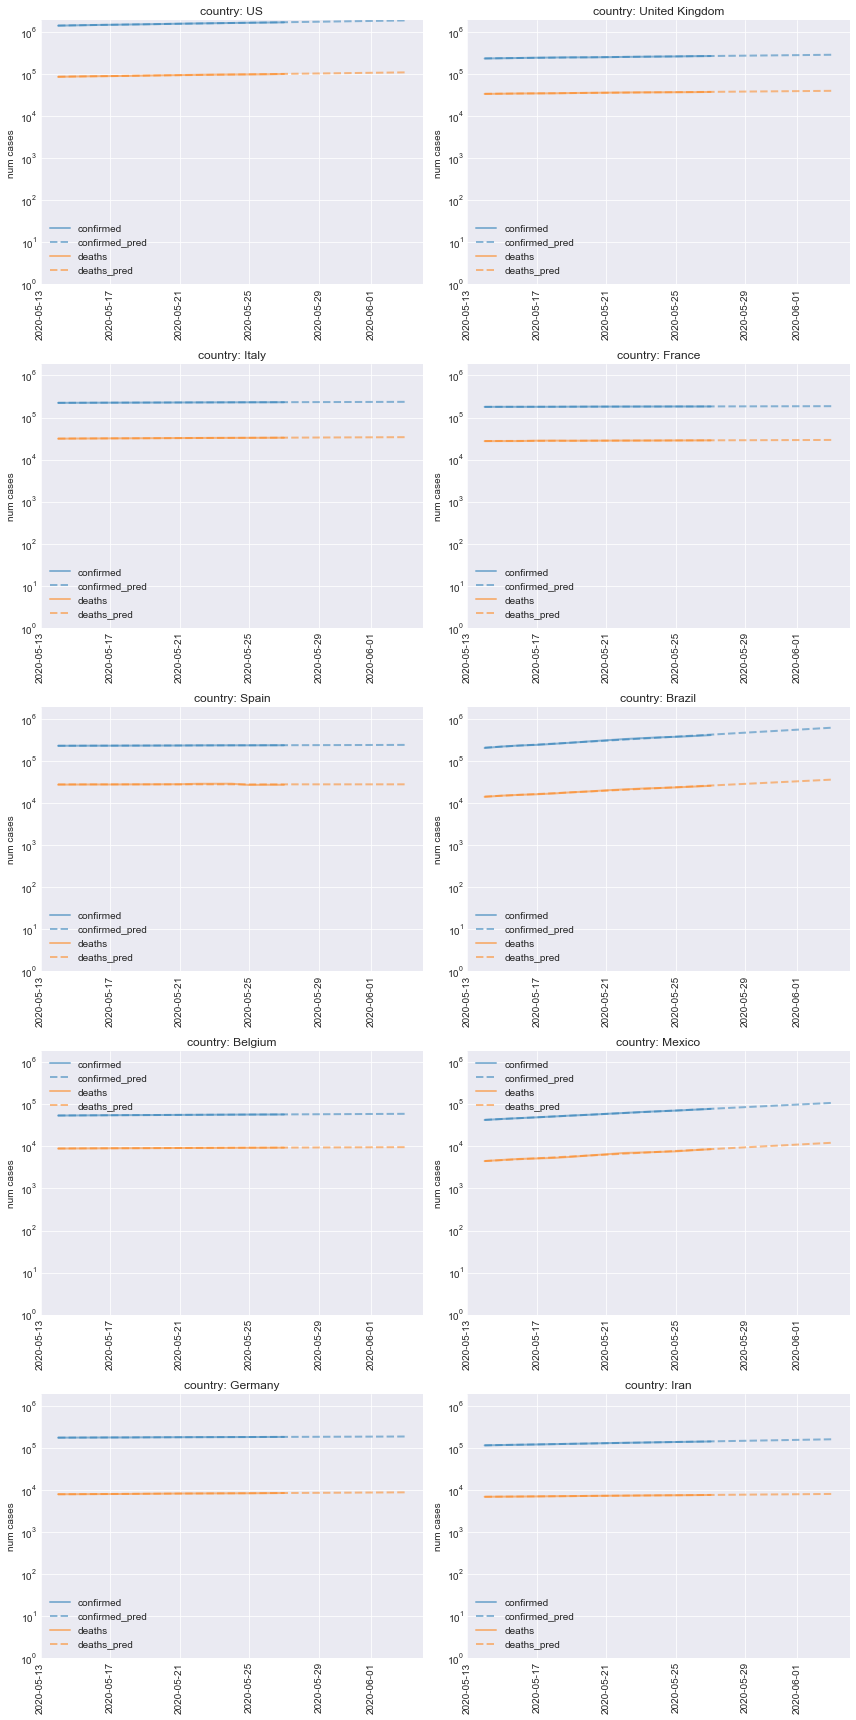

In [218]:
dfp_country_recent_2, dfp_forecasts_out_2 = fit_exp(dfp_country, 
                                                    n_days_predict=14, 
                                                    col_locale='country', 
                                                    top_countries=None
                                                   )
plot_forecasts(dfp_country_recent_2)

In [219]:
save_forecast(dfp_forecasts_out_2, dfp_country_recent_2, 14)

saved forecast to predictions/covid-19_country_forecast_from_2020-05-27_n_days_training=14.csv


<a id='time-series_country_mortality'></a>
# Time-series plots of mortality

In [220]:
def plot_mortality_rate(
    dfp, 
    locales, 
    id_col='country', 
    upper_lim=0.2, 
    date_min=datetime.datetime(2020,2,20),
    dfp_country_mortality_expected=None
):
    
    for locale in locales:
        dfp_plot = dfp[(dfp[id_col] == locale) &
                       (dfp['date'] >= date_min)
                      ]
        p = plt.plot(dfp_plot['date'], dfp_plot['mortality_rate'], label=locale, alpha=0.7)
        
        if dfp_country_mortality_expected is not None:
            dfp_expected = dfp_country_mortality_expected[dfp_country_mortality_expected['country'] == locale]
            
            color = p[0].get_color()
            expected = dfp_expected['frac_mortality'].values[0]
            plt.axhline(expected, 
                        color=color, 
                        alpha=0.5, 
                        linestyle='--', 
                        label=f'{locale} expected = {expected:0.4f}'
                       )
    #plt.legend(loc='best')
    plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
    if upper_lim is not None:
        plt.ylim([0,upper_lim])
    #plt.yscale('log')
    plt.ylabel('mortality rate')
    plt.title(f'Mortality by {id_col}')
    plt.xticks(rotation=90)
    plt.show()
    return None

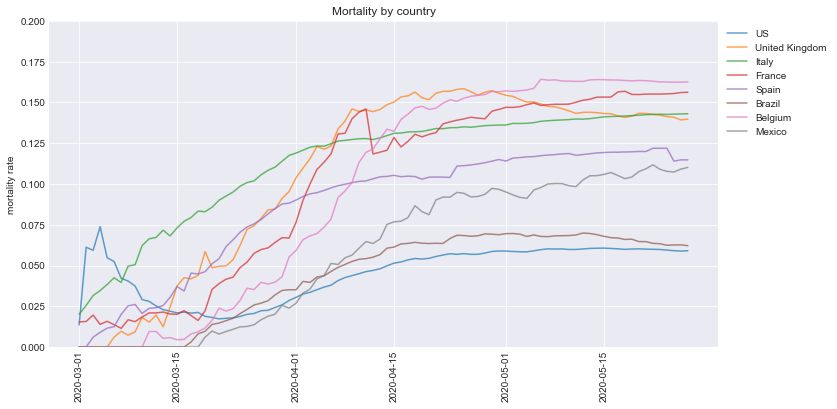

In [221]:
n_countries = 8
countries = dfp_top_countries.iloc[:n_countries]['country']

plot_mortality_rate(dfp_country, countries, upper_lim=0.2, id_col='country', date_min=datetime.datetime(2020,3,1))

### Is mortality rate a function of number of infections?

In [222]:
def plot_mortality_rate_vs_infections(
    dfp, 
    locales, 
    id_col='country', 
    upper_lim=0.2, 
    date_min=datetime.datetime(2020,2,20),
    x_col='confirmed',
    y_col='mortality_rate'
):
    
    for locale in locales:
        dfp_plot = dfp[(dfp[id_col] == locale) &
                       (dfp['date'] >= date_min)
                      ]
        plt.plot(dfp_plot[x_col], dfp_plot[y_col], 'o', label=locale, alpha=0.3)
    plt.legend(loc='best')
    #plt.ylim([0,upper_lim])
    plt.gca().set_ylim(top=upper_lim)
    plt.xscale('log')
    #plt.yscale('log')
    #plt.xlabel('# confirmed cases')
    #plt.ylabel('mortality rate')
    plt.xlabel(x_col.replace('_', ' '))
    plt.ylabel(y_col.replace('_', ' '))
    plt.title(f'{y_col} vs {x_col} by {id_col}')
    plt.xticks(rotation=90)
    plt.show()
    return None

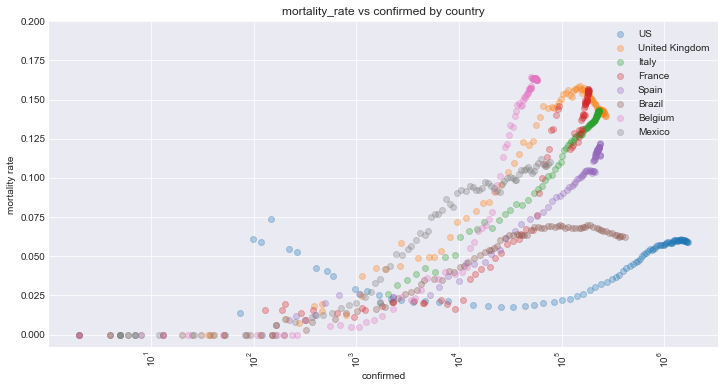

In [223]:
plot_mortality_rate_vs_infections(dfp_country, countries, upper_lim=0.2, id_col='country', date_min=datetime.datetime(2020,3,1))

# Compare mortality rate to expected given country demographics and mortality by age data?

- Country demographic data source: https://www.census.gov/data-tools/demo/idb/region.php?T=10&RT=0&A=both&Y=2020&C=AF&R=1
- Mortality by age source: https://www.worldometers.info/coronavirus/coronavirus-age-sex-demographics/

In [224]:
# mortality data
d_mortality = {0: 0, 10: 0.002, 20: 0.002, 30: 0.002, 40: 0.004, 50: 0.013, 60: 0.036, 70: 0.08, 80: 0.148, 90: 0.148, 100: 0.148}
dfp_mortality = pd.DataFrame.from_dict(d_mortality, orient='index', columns=['mortality_rate']).reset_index(drop=False)
dfp_mortality = dfp_mortality.rename(columns={'index': 'age_decade'})

# demographic data
dfp_demo = pd.read_csv('supporting_data/census_data_20200320_10a682338c.csv', skiprows=1, skipinitialspace=True)

# clean demographic data
dfp_demo = dfp_demo[(dfp_demo['Region'] == 'World') & (dfp_demo['Age'] != 'Total')]
dfp_demo['age_min'] = dfp_demo['Age'].apply(lambda x: np.min([int(y) for y in re.findall('(\d+)', x)]))
dfp_demo['age_mid'] = dfp_demo['age_min'] + 2.5
dfp_demo['age_decade'] = dfp_demo['age_min'].apply(lambda x: int(x / 10) * 10)
dfp_demo = dfp_demo.rename(columns={'Percent Both Sexes': 'pct_pop', 
                                    'Country': 'country',
                                    'Both Sexes Population': 'pop'
                                   })
dfp_demo_decade = dfp_demo.groupby(['country', 'age_decade'], as_index=False).agg({'pct_pop': np.sum, 'pop': np.sum})
dfp_demo_decade.loc[dfp_demo_decade['country'] == 'United States', 'country'] = 'US'

# join mortality with demographics
dfp_demo_decade_mortality = (dfp_demo_decade.merge(dfp_mortality, on=['age_decade'], how='inner').
                             sort_values(by=['country', 'age_decade']).
                             reset_index(drop=True)
                            )
dfp_demo_decade_mortality['frac_mortality'] = dfp_demo_decade_mortality['pct_pop'] * dfp_demo_decade_mortality['mortality_rate'] / 100
dfp_demo_decade_mortality['num_deaths_max_expected'] = dfp_demo_decade_mortality['pop'] * dfp_demo_decade_mortality['mortality_rate']
dfp_country_mortality_expected = (dfp_demo_decade_mortality.
                                  groupby(['country'], as_index=False).
                                  agg({'frac_mortality': np.sum, 
                                       'num_deaths_max_expected': np.sum, 
                                       'pop': np.sum
                                      })
                                 )
dfp_country_mortality_expected.loc[dfp_country_mortality_expected['country'] == 'United States', 'country'] = 'US'

### Age distributions for most infected countries

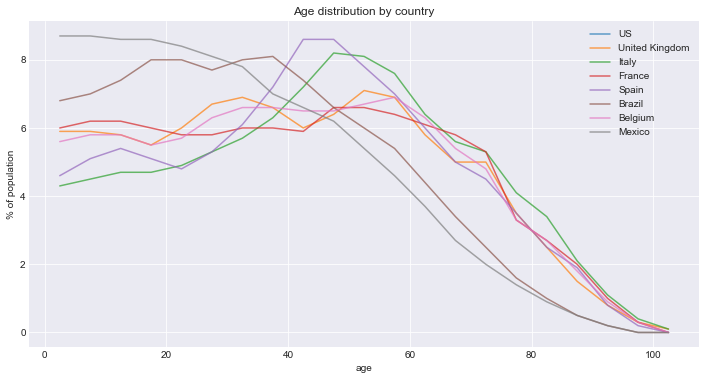

In [225]:
n_countries = 8
countries = dfp_top_countries.iloc[:n_countries]['country']
for country in countries:
    dfp_plot = dfp_demo[dfp_demo.country == country]
    plt.plot(dfp_plot['age_mid'], dfp_plot['pct_pop'], alpha=0.7, label=country)
plt.xlabel('age')
plt.ylabel('% of population')
plt.title('Age distribution by country')
plt.legend(loc='best')
plt.show()

<a id='counry_mortality_expectations'></a>
### Mortality as currently measured, compared to expected based on WHO mortality expectations

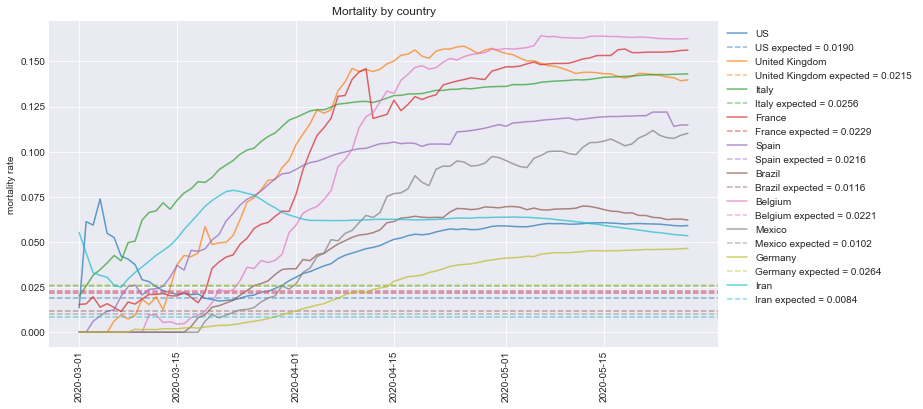

date         country  mortality_rate  confirmed    deaths
0 2020-05-27         Belgium        0.162592    57592.0    9364.0
1 2020-05-27          France        0.156246   183038.0   28599.0
2 2020-05-27           Italy        0.143083   231139.0   33072.0
3 2020-05-27  United Kingdom        0.139759   268619.0   37542.0
4 2020-05-27           Spain        0.114777   236259.0   27117.0
5 2020-05-27          Mexico        0.110185    78023.0    8597.0
6 2020-05-27          Brazil        0.062158   411821.0   25598.0
7 2020-05-27              US        0.059098  1699176.0  100418.0
8 2020-05-27            Iran        0.053421   141591.0    7564.0
9 2020-05-27         Germany        0.046429   181524.0    8428.0

In [226]:
n_countries = 10
countries = dfp_top_countries.iloc[:n_countries]['country']

plot_mortality_rate(dfp_country, countries, upper_lim=None, id_col='country', date_min=datetime.datetime(2020,3,1), dfp_country_mortality_expected=dfp_country_mortality_expected)
dfp_display = (dfp_country[(dfp_country['date'] == dfp_country['date'].max()) & 
                           (dfp_country['country'].isin(countries))
                          ].
               sort_values(by='mortality_rate', ascending=0).
               reset_index(drop=True)
              )[['date', 'country', 'mortality_rate', 'confirmed', 'deaths']]
display(dfp_display)

**Remarks about the mortality rate being above the expected mortality rate**

Assuming the [cited report](https://www.worldometers.info/coronavirus/coronavirus-age-sex-demographics/) of age-wise mortality is correct and that the virus is homogeneously distributed amongst the population, a discrepancy like this could arise if the country has:
- Preferentially tested people in critical condition, ignoring test for mild cases (perhaps if testing capacity is saturated)
- An overloaded hospital system, where patients are not receiving the same quality of care they would otherwise

If the testing is biased, we can estimate the true number of infections by multiplying the confirmed cases by the ratio between the measured mortality rate and the expected mortality rate.  For example, in Iran (as of 2020-03-22), we might estimate the true number of cases is 9.3x higher using this method (200,589 vs 21,638).

### Distribution of expected mortality fractions

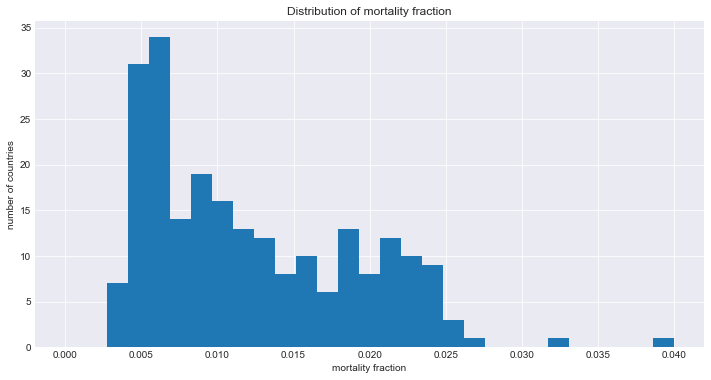

In [227]:
dfp_country_mortality_expected['frac_mortality'].hist(bins=np.linspace(0,0.04,30))
plt.title('Distribution of mortality fraction')
plt.ylabel('number of countries')
plt.xlabel('mortality fraction')
plt.show()

### Top expected mortality fractions based on age demographics
For countries with populations greater than 10 million.

In [228]:
dfp_country_mortality_expected = dfp_country_mortality_expected.sort_values(by='frac_mortality', ascending=0).reset_index(drop=True)
dfp_country_mortality_expected[dfp_country_mortality_expected['pop'] > 1E7].head(10)

country  frac_mortality  num_deaths_max_expected        pop
1         Japan        0.031837              3998380.024  125507472
2       Germany        0.026398              2128411.026   80159662
3        Greece        0.025745               271233.247   10607051
4         Italy        0.025637              1599267.592   62402659
10     Portugal        0.023736               244829.259   10302674
18       France        0.022950              1564984.503   67848156
20       Sweden        0.022575               231555.716   10202491
23      Belgium        0.022146               259573.363   11720716
24  Netherlands        0.022076               382222.125   17280397
27       Canada        0.021712               820035.480   37694085

<a id='density_of_infections_by_country'></a>
# Density of infections per million people

In [229]:
# plot of country fractions that are infected
dfp_country_pop = dfp_country.merge(dfp_country_mortality_expected[['country', 'pop']], on='country', how='left').copy()
dfp_country_pop['deaths_per_million'] = dfp_country_pop['deaths'] / dfp_country_pop['pop'] * 1E6
dfp_country_pop['confirmed_per_million'] = dfp_country_pop['confirmed'] / dfp_country_pop['pop'] * 1E6

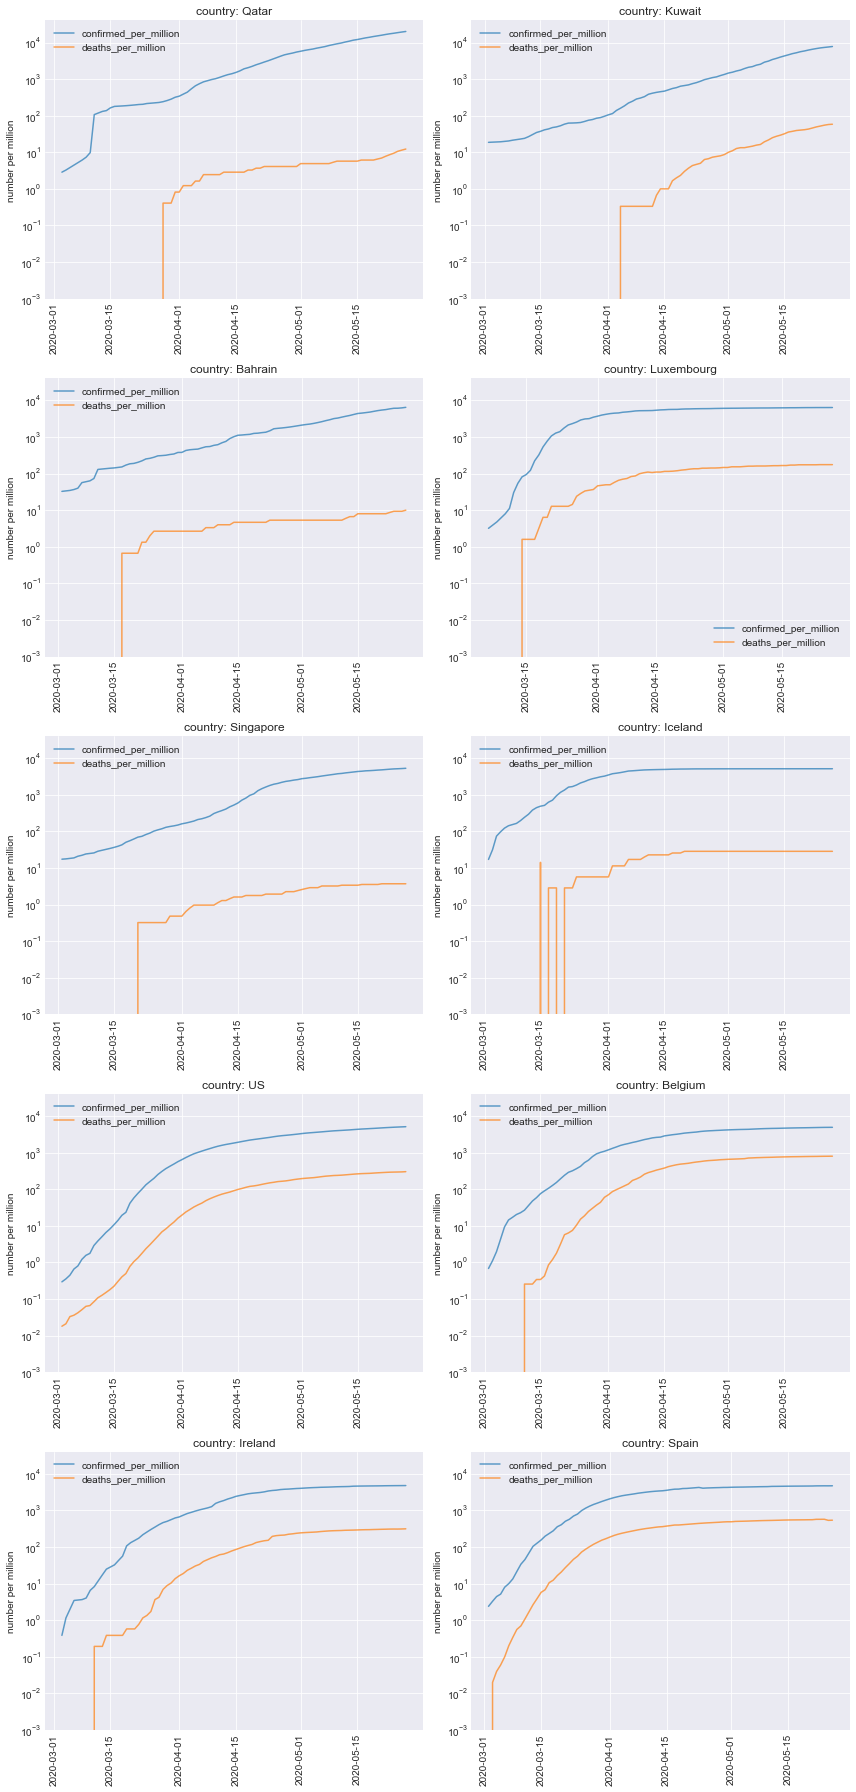

country   population  confirmed    deaths  confirmed_per_million  \
0       Qatar    2444174.0    48947.0      30.0           20025.988330   
1      Kuwait    2993706.0    23267.0     175.0            7771.972264   
2     Bahrain    1505003.0     9692.0      15.0            6439.854273   
3  Luxembourg     628381.0     4001.0     110.0            6367.156232   
4   Singapore    6209660.0    32876.0      23.0            5294.331735   
5     Iceland     350734.0     1805.0      10.0            5146.350226   
6          US  332639102.0  1699176.0  100418.0            5108.166748   
7     Belgium   11720716.0    57592.0    9364.0            4913.692986   
8     Ireland    5176569.0    24803.0    1631.0            4791.397545   
9       Spain   50015792.0   236259.0   27117.0            4723.688070   

   deaths_per_million  mortality_rate  
0           12.274085        0.000613  
1           58.455974        0.007521  
2            9.966758        0.001548  
3          175.053033        0.027493  
4            3.703906        0.000700  
5           28.511636        0.005540  
6          301.882729        0.059098  
7          798.927301        0.162592  
8          315.073555        0.065758  
9          542.168761        0.114777

In [230]:
n_countries = 10
dfp_country_pop_top = (dfp_country_pop[(dfp_country_pop['date'] == dfp_country_pop['date'].max()) &
                                       (dfp_country_pop['pop'] >= 1E5)
                                      ].
                       sort_values(by='confirmed_per_million', ascending=0).
                       reset_index(drop=True)
                      )

plot_countries(dfp_country_pop, 
               countries=dfp_country_pop_top.iloc[:n_countries]['country'],
               plot_cols=['confirmed_per_million', 'deaths_per_million'],
               country_col='country',
               y_max=dfp_country_pop['confirmed_per_million'].max()*2,
               y_min=0.001,
               y_label='number per million',
               date_min=datetime.datetime(2020,3,2)
              )
display_cols = ['country', 'pop', 'confirmed', 'deaths', 'confirmed_per_million', 'deaths_per_million', 'mortality_rate']
display(dfp_country_pop_top[display_cols].rename(columns={'pop': 'population'}).head(10))

In [231]:
dfp_country_pop_top[display_cols].sort_values(by='deaths_per_million', ascending=0).head(10)

country          pop  confirmed    deaths  confirmed_per_million  \
7          Belgium   11720716.0    57592.0    9364.0            4913.692986   
13  United Kingdom   65761117.0   268619.0   37542.0            4084.769424   
9            Spain   50015792.0   236259.0   27117.0            4723.688070   
15           Italy   62402659.0   231139.0   33072.0            3703.992806   
22          France   67848156.0   183038.0   28599.0            2697.759391   
17          Sweden   10202491.0    35088.0    4220.0            3439.160103   
23     Netherlands   17280397.0    45970.0    5890.0            2660.239808   
8          Ireland    5176569.0    24803.0    1631.0            4791.397545   
6               US  332639102.0  1699176.0  100418.0            5108.166748   
16     Switzerland    8403994.0    30776.0    1917.0            3662.068298   

    deaths_per_million  mortality_rate  
7           798.927301        0.162592  
13          570.884464        0.139759  
9           542.168761        0.114777  
15          529.977417        0.143083  
22          421.514772        0.156246  
17          413.624477        0.120269  
23          340.848651        0.128127  
8           315.073555        0.065758  
6           301.882729        0.059098  
16          228.105827        0.062289

### Mortality rate by deaths per capita, confirmed per capita

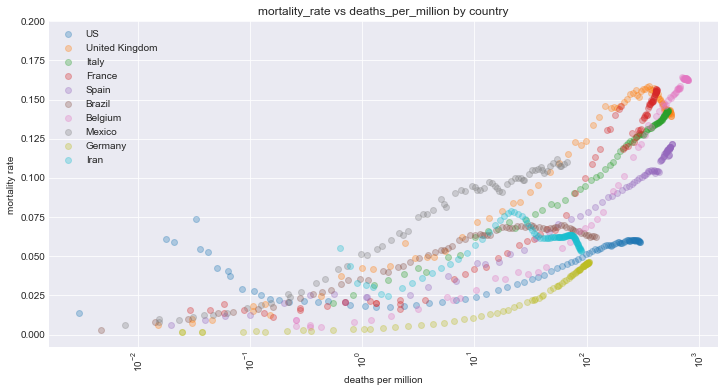

In [232]:
plot_mortality_rate_vs_infections(dfp_country_pop, 
                                  countries, 
                                  upper_lim=0.2, 
                                  id_col='country', 
                                  date_min=datetime.datetime(2020,3,1), 
                                  x_col='deaths_per_million', 
                                  y_col='mortality_rate'
                                 )

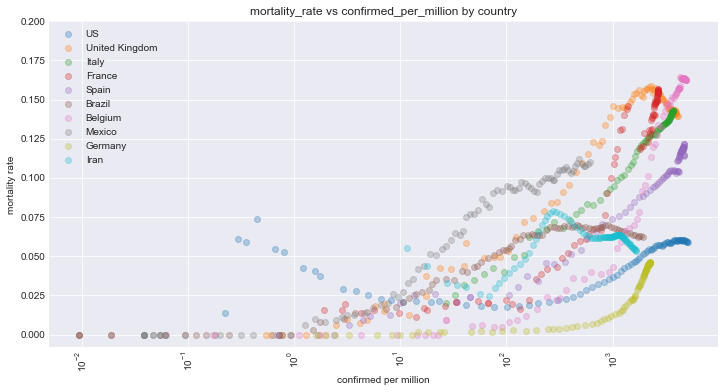

In [233]:
plot_mortality_rate_vs_infections(dfp_country_pop, 
                                  countries, 
                                  upper_lim=0.2, 
                                  id_col='country', 
                                  date_min=datetime.datetime(2020,3,1), 
                                  x_col='confirmed_per_million', 
                                  y_col='mortality_rate'
                                 )

<a id='days_behind'></a>
# How many days behind is each country from Italy?

In [234]:
def days_behind_multi_country(
    countries_compare, 
    country_base, 
    dfp=dfp_country_pop, 
    n_days=14, 
    country_col='country',
    compare_col='confirmed_frac'
):
#     country_compare = 'Spain'
#     country_base = 'Italy'
    countries = [country_base] + countries_compare
    #n_days = 14  # compare the lag over the last n_days

    # compare the fraction of cases directly
    list_dfp_compare = []
    d_dfp_compare = {}

    for i, country in enumerate(countries):
        dfp_p = dfp[dfp[country_col] == country]
        dfp_p = dfp_p.sort_values(by='date', ascending=0).reset_index(drop=True)
        
        if country == country_base:
            line_style = '-'
            dfp_comp = dfp_p.copy()
            alpha=1
        else:
            line_style = '--'
            list_dfp_compare.append(dfp_p)
            d_dfp_compare[country] = dfp_p
            alpha=0.7
        
        plt.plot(dfp_p['date'], dfp_p['confirmed'], linestyle=line_style, alpha=alpha, label=country)
        
    plt.legend(loc='best')
    plt.title('Raw number of cases')
    plt.ylabel('cases')
    plt.yscale('log')
    plt.show()


    # compute the best estimate of the lag between countries
    # this assumes that the best metric is density of cases
    # though this may be more dependent on localities
    metric = compare_col
    delta_col = f'delta_{metric}'
    list_series = []

    for country, dfp_test in d_dfp_compare.items():
        list_series = []
        delta_col = f'delta_{metric}_{country}'
        for i, row in dfp_test[:n_days].iterrows():
            dfp_comp[delta_col] = np.abs(dfp_comp[metric] - row[metric])
            min_loc = dfp_comp[delta_col] == dfp_comp[delta_col].min()
            #print(row['date'] - dfp_comp[min_loc]['date'])
            days_diff = pd.to_timedelta(row['date'] - dfp_comp[min_loc]['date']).astype('timedelta64[D]').values[0]
            row['days_diff'] = days_diff
            row['country_compare'] = country
            list_series.append(row)

        # plot days behind
        dfp_days_behind = pd.concat(list_series, axis=1).T
        plt.plot(dfp_days_behind['date'], dfp_days_behind['days_diff'], label=country, alpha=0.5)
        mean_days_diff = dfp_days_behind['days_diff'].mean()#{str(dfp['date'].max())}
        date_max = dfp['date'].max().strftime('%Y-%m-%d')
    plt.axhline(0, label='0', color='k', linestyle='--', alpha=0.5)
    #print(f'Computing how far behind a country is using the {compare_col} column:')
    plt.title(f'Number days each {country_col} is from {country_base} as of {date_max} using {compare_col}')
    plt.ylabel('# days')
    plt.legend(loc='best')
    plt.show()
    return dfp_days_behind

##### Days behind Italy via density of cases

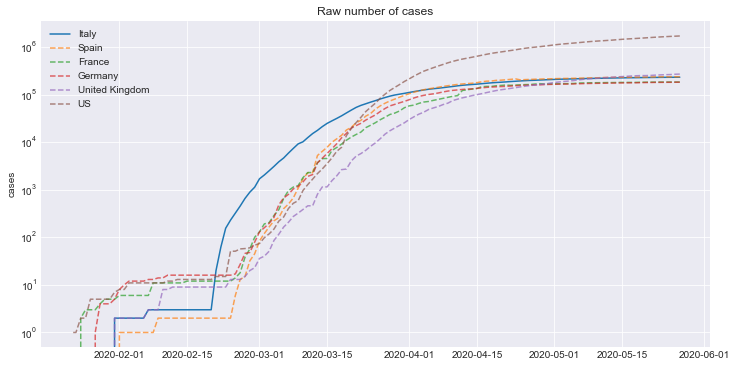

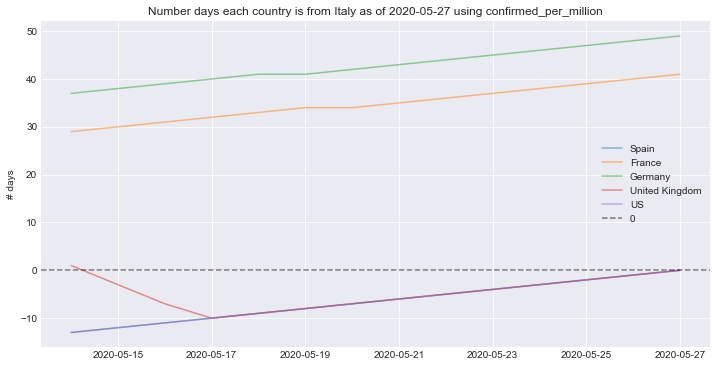

In [235]:
_ = days_behind_multi_country(['Spain', 'France', 'Germany', 'United Kingdom', 'US'], 'Italy', dfp=dfp_country_pop, compare_col='confirmed_per_million')

##### Days behind Italy via number of confirmed cases

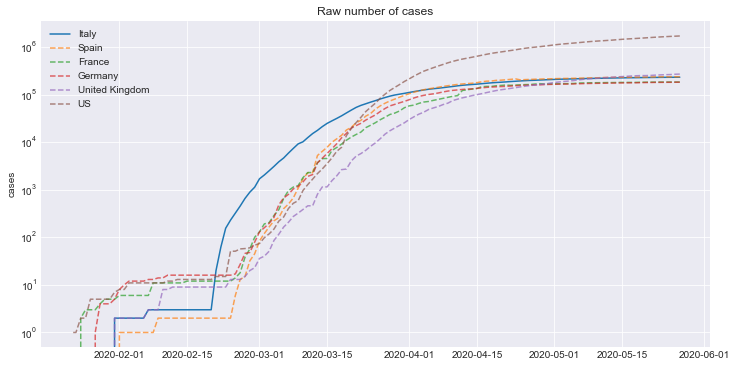

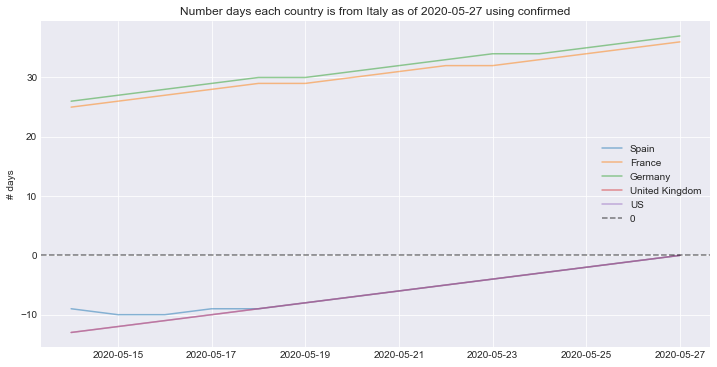

In [236]:
_ = days_behind_multi_country(['Spain', 'France', 'Germany', 'United Kingdom', 'US'], 'Italy', dfp=dfp_country_pop, compare_col='confirmed')

# US state breakdown

In [237]:
# load and clean data
dfp_us_raw = pd.read_csv('state_data/states-daily.csv')
dfp_us_raw = dfp_us_raw.rename(columns={'state': 'state_clean_1',
                                        'positive': 'confirmed',
                                        'death': 'deaths',
                                        'date': 'date_str'
                                       })
dfp_us_raw['date'] = dfp_us_raw['date_str'].apply(lambda x: datetime.datetime.strptime(str(x), '%Y%m%d'))
dfp_us_raw['country'] = 'US'

In [238]:
# load and clean data from CSSEGIS
state_base_dir = '../COVID-19/csse_covid_19_data/csse_covid_19_daily_reports/'
data_paths_raw = os.listdir(state_base_dir)
data_paths = [path for path in data_paths_raw if path.endswith('csv')]
list_dfp_states = []
cols_of_interest = ['country', 'state', 'date', 'confirmed', 'deaths', 'recovered']
for path in data_paths:
    full_path = os.path.join(state_base_dir, path)
    
    # read state data
    dfp_temp = pd.read_csv(full_path)
    cols = list(dfp_temp.columns)
    
    # clean column names
    cols_translate = {'Country/Region': 'country',
                      'Province/State': 'state',
                      'Confirmed': 'confirmed',
                      'Deaths': 'deaths',
                      'Recovered': 'recovered',
                      'Country_Region': 'country',
                      'Province_State': 'state',
                      'Last_Update': 'Last Update'
                     }
    dfp_temp = dfp_temp.rename(columns=cols_translate)
    dfp_temp['date'] = dfp_temp['Last Update'].apply(lambda x: parser.parse(x).date())
    dfp_temp['date'] = dfp_temp['date'].apply(lambda x: datetime.datetime(x.year, x.month, x.day))
    dfp_temp = dfp_temp[dfp_temp['country'] == 'US']
    list_dfp_states.append(dfp_temp[cols_of_interest])
dfp_us_raw = pd.concat(list_dfp_states)
dfp_us_raw['state_clean_1'] = dfp_us_raw['state'].apply(lambda x: re.findall('\, ([A-Z]{2}$)', x)[0].strip() if re.findall('\, ([A-Z]{2}$)', x) else x)

In [239]:
# look only at the US
#dfp_us_raw = dfp[dfp['country'] == 'US'].copy()
#dfp_us_raw['state_clean_1'] = dfp_us_raw['state'].apply(lambda x: re.findall('\, ([A-Z]{2})', x)[0].strip() if re.findall('\, ([A-Z]{2})', x) else x)

# load codes to convert two-letter codes to state names
dfp_state_codes = pd.read_csv('supporting_data/us_state_to_two_letter_code.csv')
dfp_state_codes = dfp_state_codes.rename(columns={'state': 'state_name'})
dfp_us = dfp_us_raw.merge(dfp_state_codes, left_on=['state_clean_1'], right_on=['two_letter_code'], how='left')

In [240]:
# get the most appropriate state name
dfp_us['abbrev'] = ~dfp_us['state_name'].isnull()
dfp_us['state_clean'] = dfp_us.apply(lambda x: x['state_name'] if x['abbrev'] else x['state_clean_1'], axis=1)

# aggregate infections by state
dfp_us_g = (dfp_us.groupby(['date', 'country', 'state_clean'], as_index=False).
            agg({
                'confirmed': np.sum,
                'deaths': np.sum,
                #'recovered': np.sum,
               })
           )
dfp_us_g = dfp_us_g.sort_values(by='date')
dfp_us_g = dfp_us_g.rename(columns={'state_clean': 'state'})
#dfp_us_g['active'] = dfp_us_g['confirmed'] - dfp_us_g['recovered']
dfp_us_g['confirmed_lag1'] = dfp_us_g.groupby(['country', 'state'])['confirmed'].shift(1)
dfp_us_g['deaths_lag1'] = dfp_us_g.groupby(['country', 'state'])['deaths'].shift(1)
dfp_us_g['confirmed_new'] = dfp_us_g['confirmed'] - dfp_us_g['confirmed_lag1']
dfp_us_g['deaths_new'] = dfp_us_g['deaths'] - dfp_us_g['deaths_lag1']
dfp_us_g['deaths_new'] = dfp_us_g['deaths_new'].fillna(0)
dfp_us_g['mortality_rate'] = dfp_us_g['deaths'] / dfp_us_g['confirmed']

<a id='states_most_infections'></a>
### US states with the most new infections

In [241]:
id_cols_state = ['date', 'state']
value_cols_state = ['confirmed', 'confirmed_new', 'deaths', 'deaths_new', 'mortality_rate']

dfp_us_top_states = dfp_us_g[dfp_us_g['date'] == dfp_us_g['date'].max()][id_cols_state + value_cols_state]
dfp_us_top_states = dfp_us_top_states.sort_values(by='deaths', ascending=0).reset_index(drop=True)
dfp_us_top_states = dfp_us_top_states.fillna(0)
for key in value_cols_state:
    if 'rate' in key:
        continue
    dfp_us_top_states[key] = dfp_us_top_states[key].apply(int)
dfp_us_top_states.head(15)

date          state  confirmed  confirmed_new  deaths  deaths_new  \
0  2020-05-28       New York     364965           1129   29484         182   
1  2020-05-28     New Jersey     156628            864   11339         145   
2  2020-05-28  Massachusetts      94220            527    6547          74   
3  2020-05-28       Michigan      55608            504    5334          68   
4  2020-05-28   Pennsylvania      73557            779    5265         102   
5  2020-05-28       Illinois     114306           1111    5083         160   
6  2020-05-28     California     101050           1663    3895          76   
7  2020-05-28    Connecticut      41288            -15    3803          34   
8  2020-05-28      Louisiana      38497            443    2723          21   
9  2020-05-28       Maryland      48423            736    2392          59   
10 2020-05-28        Florida      52634            379    2319          60   
11 2020-05-28           Ohio      33439            433    2044          42   
12 2020-05-28        Indiana      32437            359    2030          26   
13 2020-05-28        Georgia      44638            655    1933          37   
14 2020-05-28          Texas      58542           1312    1581          35   

    mortality_rate  
0         0.080786  
1         0.072394  
2         0.069486  
3         0.095921  
4         0.071577  
5         0.044468  
6         0.038545  
7         0.092109  
8         0.070733  
9         0.049398  
10        0.044059  
11        0.061126  
12        0.062583  
13        0.043304  
14        0.027006

<a id='time-series_states'></a>
### Time-series plots of infections in most-infected states

In [242]:
def plot_state_data(dfp_us_g, states_oi, plot_col='confirmed', date_min=datetime.datetime(2020, 2, 25)):
    for state in states_oi:
        dfp_s = dfp_us_g[(dfp_us_g['state'] == state) & (dfp_us_g['date'] >= date_min)]
        plt.plot(dfp_s['date'], dfp_s[plot_col], label=state, alpha=0.5)
    plt.ylabel('# cases')
    plt.xticks(rotation=90)
    plt.title(f'{plot_col} in: {", ".join(states_oi)}')
    plt.yscale('log')
    plt.legend(loc='best')
    plt.show()
    return None

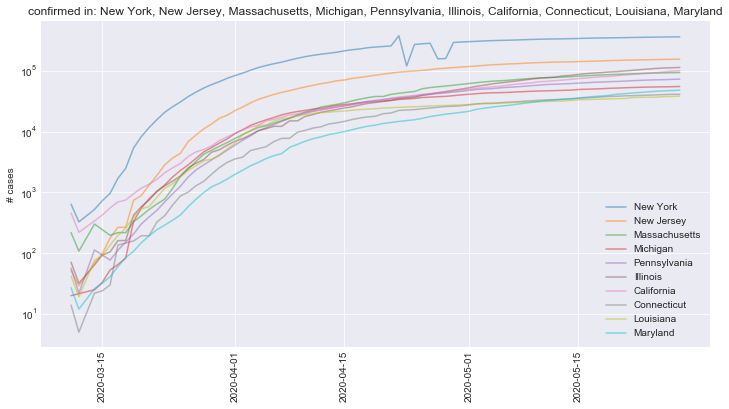

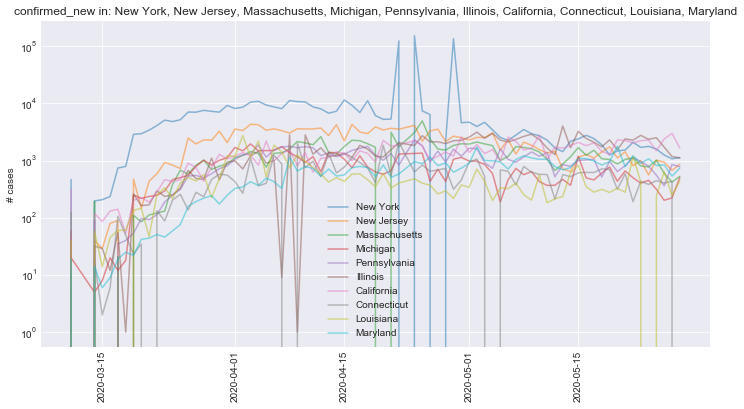

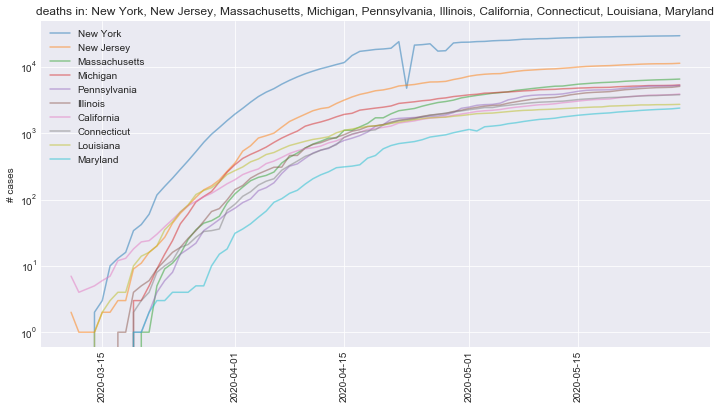

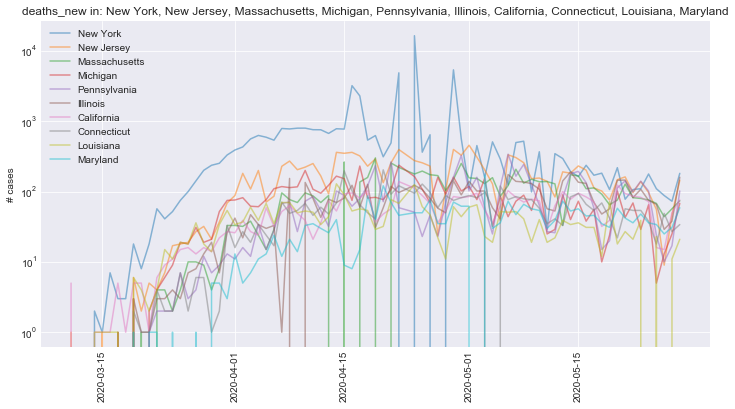

In [243]:
states_oi = dfp_us_top_states.iloc[:10]['state'].values
dt_min = datetime.datetime(2020,3,11)
plot_state_data(dfp_us_g, states_oi, plot_col='confirmed', date_min=dt_min)
plot_state_data(dfp_us_g, states_oi, plot_col='confirmed_new', date_min=dt_min)
plot_state_data(dfp_us_g, states_oi, plot_col='deaths', date_min=dt_min)
plot_state_data(dfp_us_g, states_oi, plot_col='deaths_new', date_min=dt_min)

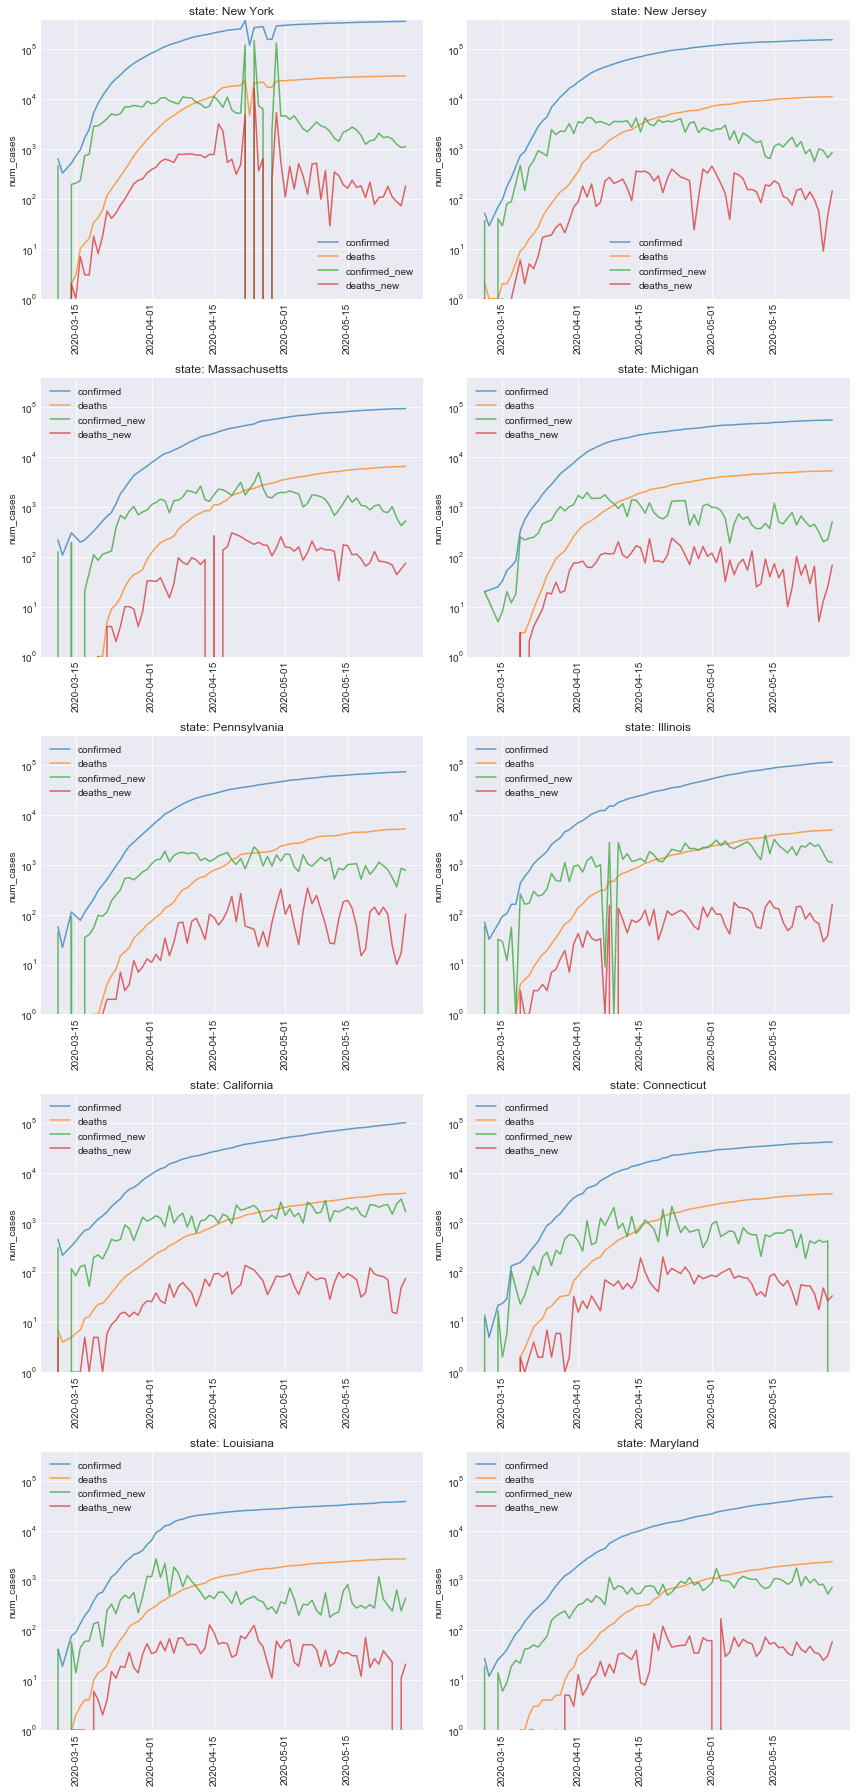

In [244]:
plot_countries(dfp_us_g, 
               countries=dfp_us_top_states.iloc[:10]['state'].values,
               plot_cols=['confirmed', 'deaths', 'confirmed_new', 'deaths_new'], #, 'recovered', 'active'
               country_col='state',
               date_min=datetime.datetime(2020,3,11),
               y_max=dfp_us_g['confirmed'].max()
              )

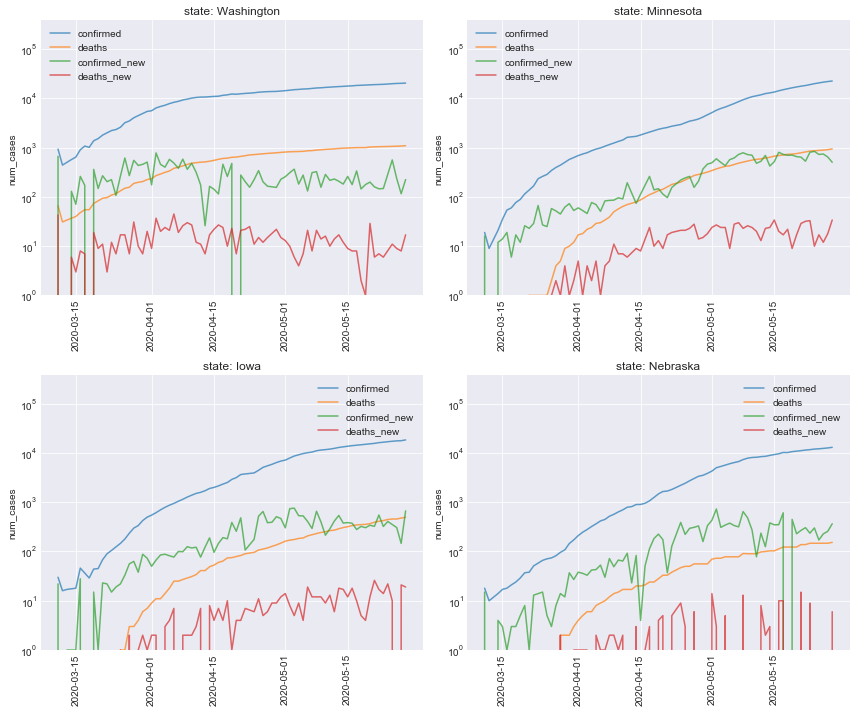

In [245]:
plot_countries(dfp_us_g, 
               countries=['Washington', 'Minnesota', 'Iowa', 'Nebraska'],
               plot_cols=['confirmed', 'deaths', 'confirmed_new', 'deaths_new'], #, 'recovered', 'active'
               country_col='state',
               date_min=datetime.datetime(2020,3,11),
               y_max=dfp_us_g['confirmed'].max()
              )

<a id='forecast_us_state'></a>
### Forecast by state

##### 1 week of data

confirmed_pred                       deaths_pred             \
date              2020-05-29 2020-06-04 2020-06-18  2020-05-29 2020-06-04   
state                                                                       
New York            366800.0   375556.0   396808.0     29589.0    30321.0   
New Jersey          157512.0   162732.0   175594.0     11387.0    11827.0   
Massachusetts        95196.0    99638.0   110827.0      6616.0     7030.0   
Michigan             55905.0    57961.0    63057.0      5347.0     5537.0   
Pennsylvania         74220.0    78566.0    89723.0      5323.0     5678.0   
Illinois            117445.0   130778.0   168076.0      5119.0     5579.0   
California          103574.0   118990.0   164479.0      3931.0     4229.0   
Connecticut          41911.0    44296.0    50403.0      3844.0     4071.0   
Louisiana            38729.0    40802.0    46082.0      2735.0     2818.0   
Maryland             49510.0    55075.0    70613.0      2421.0     2662.0   

                         mortality_rate_pred                        \
date          2020-06-18          2020-05-29 2020-06-04 2020-06-18   
state                                                                
New York         32100.0            0.080668   0.080736   0.080896   
New Jersey       12921.0            0.072293   0.072678   0.073585   
Massachusetts     8101.0            0.069499   0.070555   0.073096   
Michigan          6005.0            0.095644   0.095530   0.095231   
Pennsylvania      6601.0            0.071719   0.072270   0.073571   
Illinois          6817.0            0.043586   0.042660   0.040559   
California        5014.0            0.037954   0.035541   0.030484   
Connecticut       4655.0            0.091718   0.091904   0.092356   
Louisiana         3021.0            0.070619   0.069065   0.065557   
Maryland          3325.0            0.048899   0.048334   0.047088   

              frac_increase_confirmed frac_increase_deaths  
date                                                        
state                                                       
New York                     0.003940             0.004081  
New Jersey                   0.005449             0.006338  
Massachusetts                0.007630             0.010174  
Michigan                     0.006037             0.005819  
Pennsylvania                 0.009529             0.010821  
Illinois                     0.018084             0.014423  
California                   0.023394             0.012235  
Connecticut                  0.009268             0.009622  
Louisiana                    0.008730             0.004987  
Maryland                     0.017910             0.016000

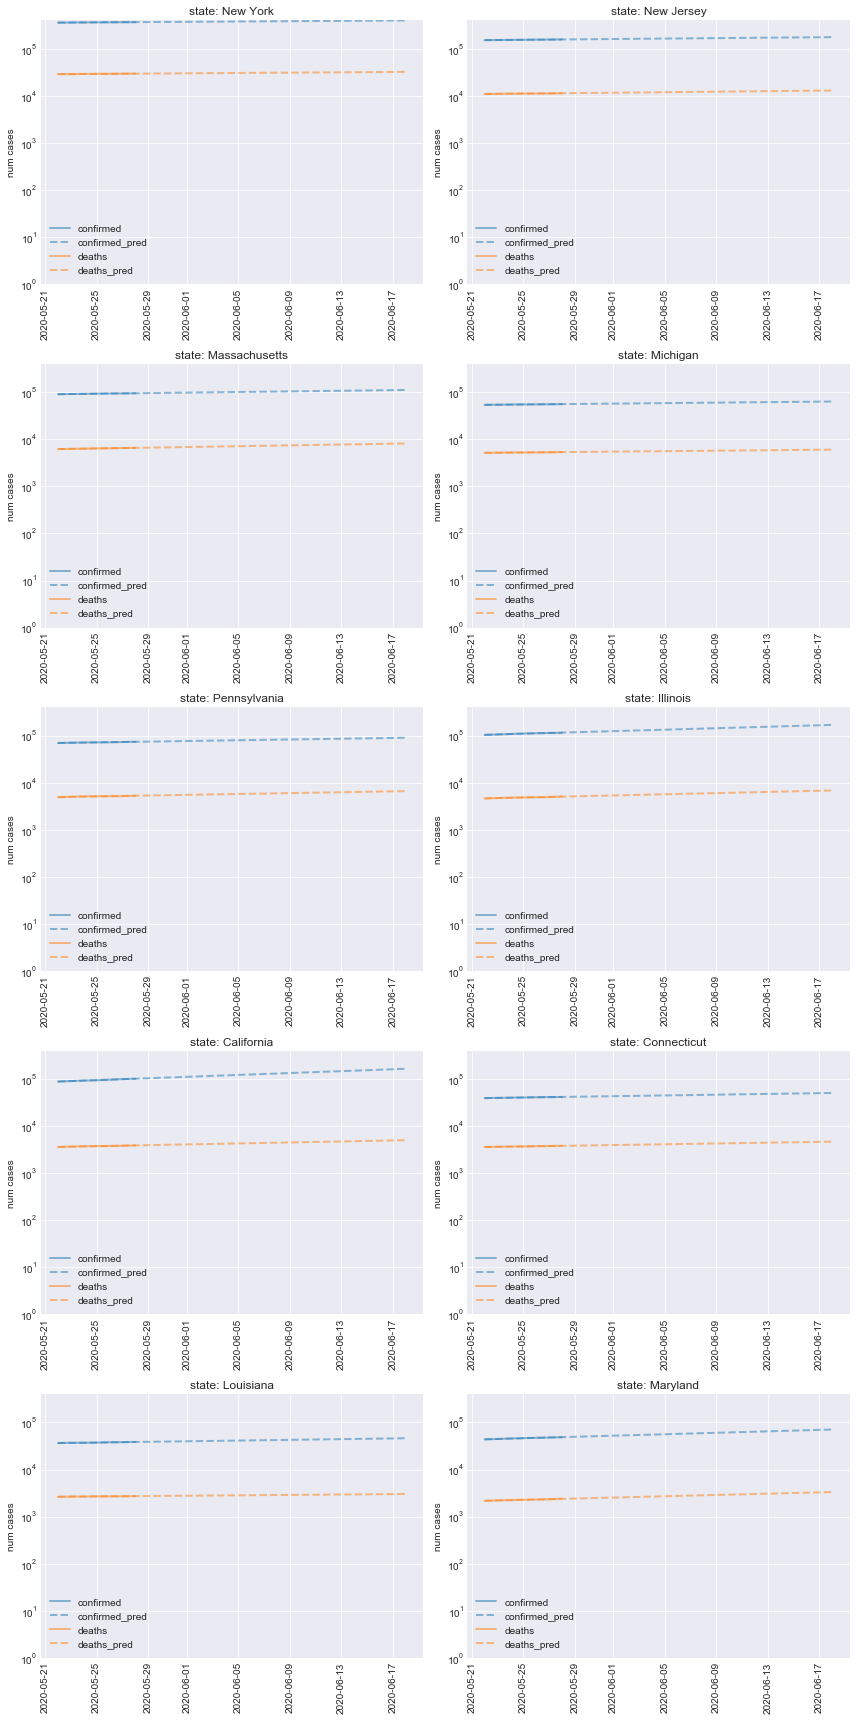

In [246]:
dfp_state_recent_1, dfp_state_forecasts_out_1 = fit_exp(dfp_us_g, 
                                                    n_days_predict=7,
                                                    n_days_into_future=[1,7,21],
                                                    col_locale='state', 
                                                    top_countries=None
                                                   )
plot_forecasts(dfp_state_recent_1, 
                   n_countries=10, 
                   n_columns=2, 
                   figsize=(12,24), 
                   date_min=datetime.datetime(2020, 2, 1),
                   col_locale='state',
                  )

##### 2 weeks of data

confirmed_pred                       deaths_pred             \
date              2020-05-29 2020-06-04 2020-06-18  2020-05-29 2020-06-04   
state                                                                       
New York            367854.0   378317.0   403904.0     29672.0    30519.0   
New Jersey          158645.0   165621.0   183117.0     11538.0    12235.0   
Massachusetts        96299.0   102577.0   118865.0      6704.0     7271.0   
Pennsylvania         74819.0    80262.0    94552.0      5421.0     5979.0   
Michigan             56549.0    59676.0    67660.0      5399.0     5682.0   
Illinois            118698.0   134566.0   180334.0      5218.0     5868.0   
California          103562.0   119057.0   164835.0      4032.0     4523.0   
Connecticut          42373.0    45454.0    53539.0      3889.0     4195.0   
Louisiana            39002.0    41695.0    48725.0      2782.0     2941.0   
Maryland             50640.0    58371.0    81317.0      2448.0     2739.0   

                         mortality_rate_pred                        \
date          2020-06-18          2020-05-29 2020-06-04 2020-06-18   
state                                                                
New York         32591.0            0.080662   0.080670   0.080690   
New Jersey       14032.0            0.072728   0.073873   0.076629   
Massachusetts     8787.0            0.069617   0.070883   0.073924   
Pennsylvania      7516.0            0.072455   0.074494   0.079491   
Michigan          6402.0            0.095475   0.095214   0.094620   
Illinois          7716.0            0.043960   0.043607   0.042787   
California        5916.0            0.038933   0.037990   0.035890   
Connecticut       5005.0            0.091780   0.092291   0.093483   
Louisiana         3349.0            0.071330   0.070536   0.068733   
Maryland          3562.0            0.048341   0.046924   0.043804   

              frac_increase_confirmed frac_increase_deaths  
date                                                        
state                                                       
New York                     0.004686             0.004703  
New Jersey                   0.007199             0.009832  
Massachusetts                0.010582             0.013622  
Pennsylvania                 0.011772             0.016469  
Michigan                     0.009010             0.008555  
Illinois                     0.021131             0.019749  
California                   0.023511             0.019354  
Connecticut                  0.011763             0.012689  
Louisiana                    0.011191             0.009324  
Maryland                     0.023964             0.018924

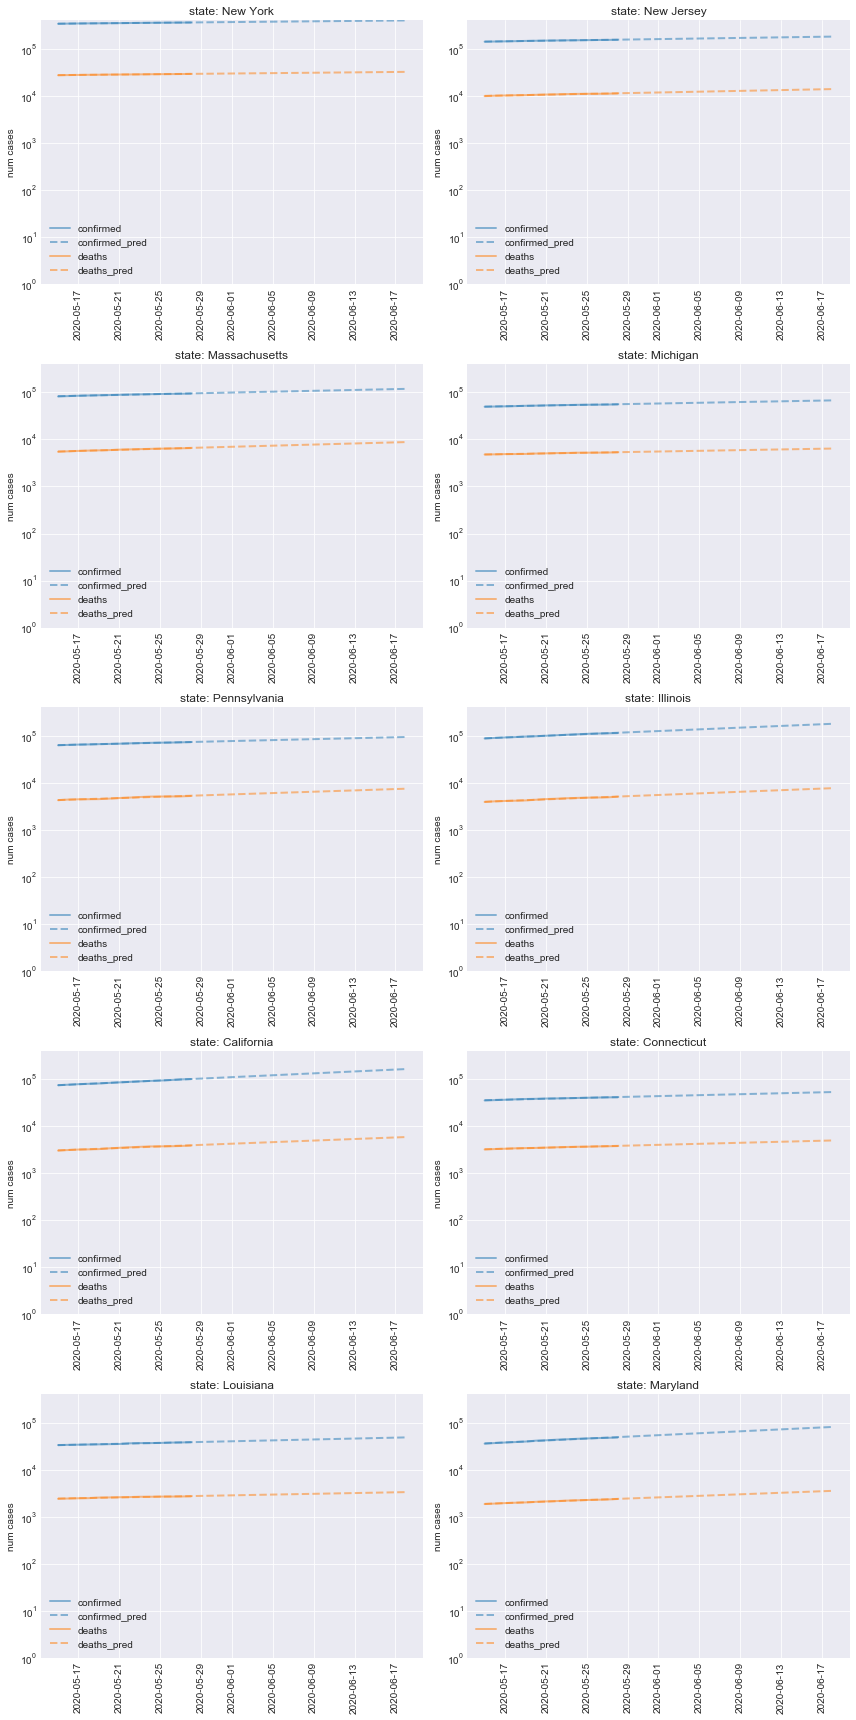

In [247]:
dfp_state_recent_2, dfp_state_forecasts_out_2 = fit_exp(dfp_us_g, 
                                                    n_days_predict=14,
                                                    n_days_into_future=[1,7,21],
                                                    col_locale='state', 
                                                    top_countries=None
                                                   )
plot_forecasts(dfp_state_recent_2, 
                   n_countries=10, 
                   n_columns=2, 
                   figsize=(12,24), 
                   date_min=datetime.datetime(2020, 2, 1),
                   col_locale='state',
                  )

<a id='us_state_daily_increase_fraction'></a>
##### States and their daily increase fraction in confirmed cases/deaths
Computed via linear fit of the log of the confirmed cases/deaths over the last 7 days.

In [248]:
# increase_cols = ['state', 'frac_increase_confirmed', 'frac_increase_deaths']
# curr_cols = ['date', 'state', 'confirmed', 'deaths']
# dfp_state_increase_m = dfp_us_g_latest[curr_cols].merge(dfp_state_increase[increase_cols], on=['state'], how='inner')
# for col in ['confirmed', 'deaths']:
#     dfp_state_increase_m[col] = dfp_state_increase_m[col].apply(int)

In [249]:
# latest date
dt_latest = dfp_us_g['date'].max()
dfp_us_g_date_max = dfp_us_g.groupby(['state'], as_index=False).agg({'date': np.max})
#dfp_us_g_latest = dfp_us_g[dfp_us_g['date'] == dt_latest].copy()
dfp_us_g_latest = dfp_us_g.merge(dfp_us_g_date_max, on=['state', 'date'], how='inner')

# what is the distribution in % increase in deaths?
dfp_state_increase = (dfp_state_forecasts_out_1[(dfp_state_forecasts_out_1['date'] == dfp_state_forecasts_out_1['date'].max()) &
                                                (dfp_state_forecasts_out_1['deaths_pred'] > 2)
                                               ].
                      sort_values(by='frac_increase_deaths', ascending=0).
                      reset_index(drop=True)
                     )
increase_cols = ['state', 'frac_increase_confirmed', 'frac_increase_deaths']
curr_cols = ['date', 'state']
int_cols = ['confirmed', 'deaths', 'deaths_new']
float_cols = ['frac_increase_confirmed', 'frac_increase_deaths']
dfp_state_increase_m = dfp_us_g_latest[curr_cols + int_cols].merge(dfp_state_increase[increase_cols], on=['state'], how='inner')
for col in int_cols:
    dfp_state_increase_m[col] = dfp_state_increase_m[col].apply(int)
for col in float_cols:
    dfp_state_increase_m[col] = dfp_state_increase_m[col].apply(lambda x: np.round(float(x),3))
(dfp_state_increase_m[curr_cols + int_cols + float_cols].
 sort_values(by='frac_increase_deaths', ascending=0).
 reset_index(drop=True)
)


date                 state  confirmed  deaths  deaths_new  \
0  2020-05-28                  Iowa      18369     496          19   
1  2020-05-28          Rhode Island      14353     655          21   
2  2020-05-28              Virginia      40249    1281          45   
3  2020-05-28           Mississippi      14044     670          18   
4  2020-05-28               Wyoming        860      14           1   
5  2020-05-28                  Utah       8706     105           4   
6  2020-05-28             Minnesota      22464     942          34   
7  2020-05-28             Tennessee      21285     353          10   
8  2020-05-28            New Mexico       7252     329           4   
9  2020-05-28        North Carolina      24916     844          43   
10 2020-05-28        South Carolina      10623     466          20   
11 2020-05-28               Alabama      16032     583           3   
12 2020-05-28                  Ohio      33439    2044          42   
13 2020-05-28              Maryland      48423    2392          59   
14 2020-05-28         New Hampshire       4286     223           9   
15 2020-05-28                 Maine       2137      81           2   
16 2020-05-28              Illinois     114306    5083         160   
17 2020-05-28              Arkansas       6277     120           1   
18 2020-05-28          North Dakota       2439      56           2   
19 2020-05-28                 Texas      58542    1581          35   
20 2020-05-28             Wisconsin      16462     539          22   
21 2020-05-28  District of Columbia       8406     445           5   
22 2020-05-28              Delaware       9096     344           9   
23 2020-05-28               Arizona      17318     834          24   
24 2020-05-28               Georgia      44638    1933          37   
25 2020-05-28          South Dakota       4710      54           4   
26 2020-05-28            California     101050    3895          76   
27 2020-05-28          Pennsylvania      73557    5265         102   
28 2020-05-28               Florida      52634    2319          60   
29 2020-05-28               Montana        481      17           0   
30 2020-05-28              Nebraska      12984     153           6   
31 2020-05-28           Connecticut      41288    3803          34   
32 2020-05-28         Massachusetts      94220    6547          74   
33 2020-05-28               Indiana      32437    2030          26   
34 2020-05-28              Oklahoma       6229     322           4   
35 2020-05-28              Colorado      24754    1392          40   
36 2020-05-28            Washington      20406    1095          17   
37 2020-05-28                Kansas       9291     213           3   
38 2020-05-28                Nevada       8150     402           8   
39 2020-05-28            New Jersey     156628   11339         145   
40 2020-05-28         West Virginia       1899      74           2   
41 2020-05-28              Michigan      55608    5334          68   
42 2020-05-28              Missouri      12816     689          -4   
43 2020-05-28                 Idaho       2699      81           2   
44 2020-05-28             Louisiana      38497    2723          21   
45 2020-05-28           Puerto Rico       3397     129           0   
46 2020-05-28              Kentucky       9077     400           6   
47 2020-05-28              New York     364965   29484         182   
48 2020-05-28                Oregon       4038     148           0   
49 2020-05-28                  Guam        170       5           0   
50 2020-05-28        Virgin Islands         69       6           0   
51 2020-05-28               Vermont        971      54           0   
52 2020-05-28                Alaska        411      10           0   
53 2020-05-28                Hawaii        644      17           0   
54 2020-05-28        Grand Princess        103       3           0   

    frac_increase_confirmed  frac_increase_deaths  
0                     0.020         

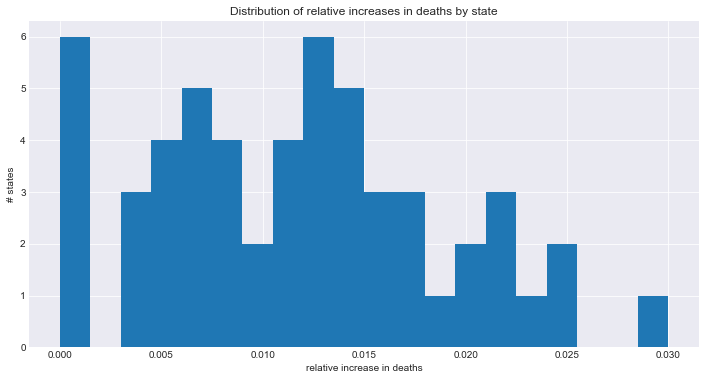

In [250]:
dfp_state_increase_m['frac_increase_deaths'].hist(bins=20)
plt.xlabel('relative increase in deaths')
plt.ylabel('# states')
plt.title('Distribution of relative increases in deaths by state')
plt.show()

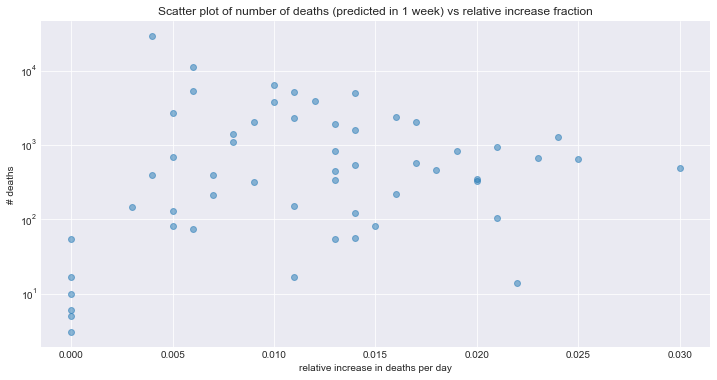

In [251]:
plt.plot(dfp_state_increase_m['frac_increase_deaths'], dfp_state_increase_m['deaths'], 'o', alpha=0.5)
#plt.xscale('log')
plt.yscale('log')
plt.xlabel('relative increase in deaths per day')
plt.ylabel('# deaths')
plt.title('Scatter plot of number of deaths (predicted in 1 week) vs relative increase fraction')
plt.show()

<a id='state_infections_vs_wa'></a>
##### Compare US state infections against Washington

In [252]:
dfp_us_g = dfp_us_g[~(dfp_us_g['date']==datetime.datetime(2020,3,9))]

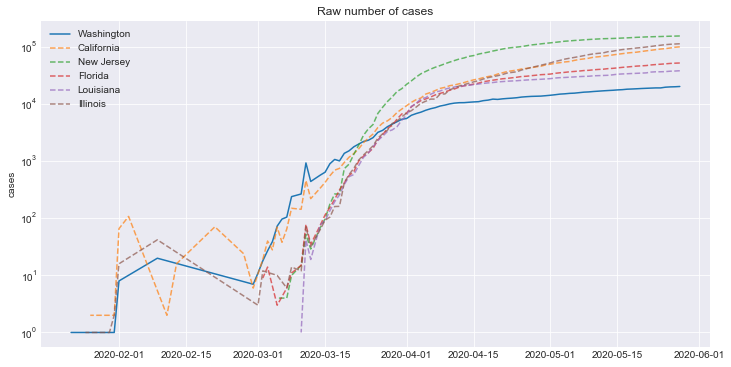

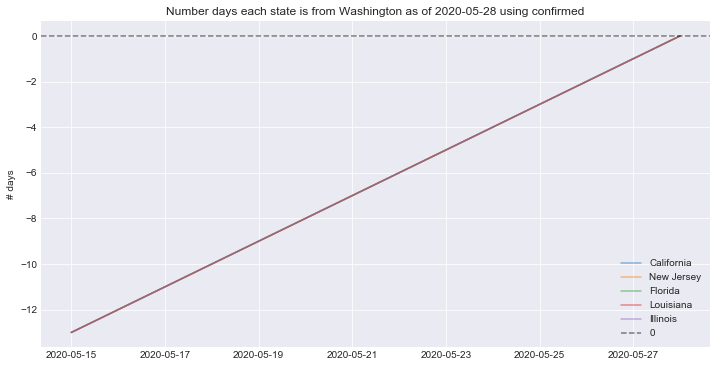

In [253]:
_ = days_behind_multi_country(['California', 'New Jersey', 'Florida', 'Louisiana', 'Illinois'], 
                              'Washington', 
                              dfp=dfp_us_g, 
                              country_col='state', 
                              compare_col='confirmed'
                             )

<a id='state_infections_vs_ny'></a>
##### Compare US state infections against New York

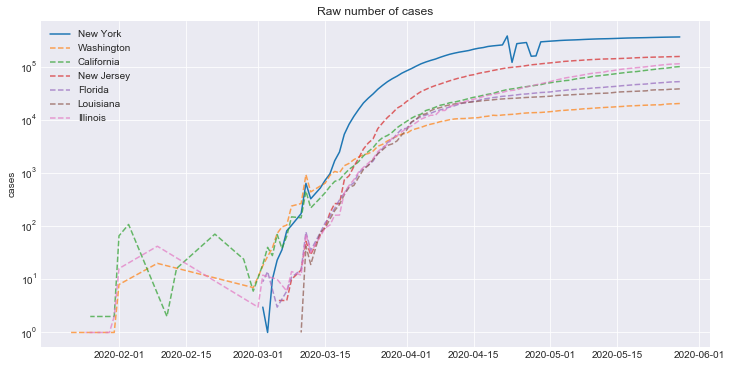

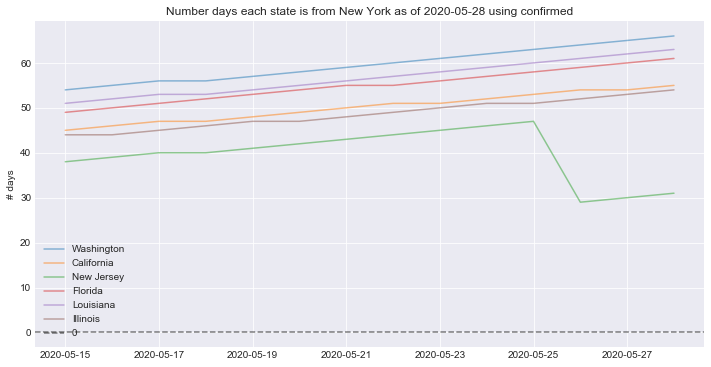

In [254]:
_ = days_behind_multi_country(['Washington', 'California', 'New Jersey', 'Florida', 'Louisiana', 'Illinois'], 
                              'New York', 
                              dfp=dfp_us_g, 
                              country_col='state', 
                              compare_col='confirmed'
                             )

<a id='mortality_by_us_state'></a>
### Mortality rate by US state

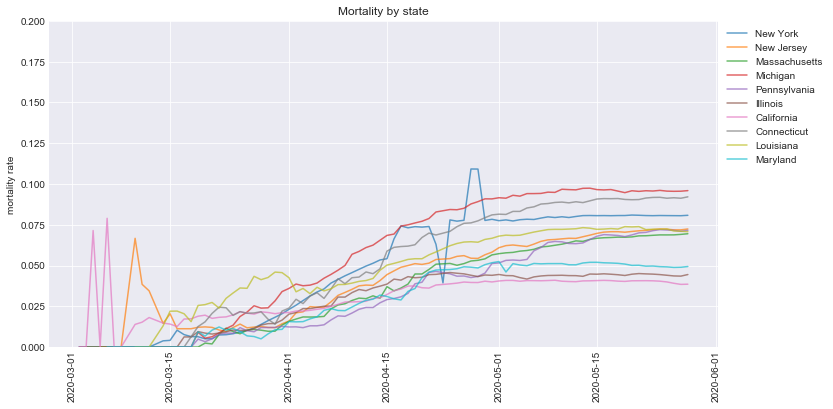

In [255]:
n_states = 10
states = dfp_us_top_states.iloc[:n_states]['state']

plot_mortality_rate(dfp_us_g, states, upper_lim=0.2, id_col='state', date_min=datetime.datetime(2020,3,2))

##### Relationship between mortality rate and number of cases

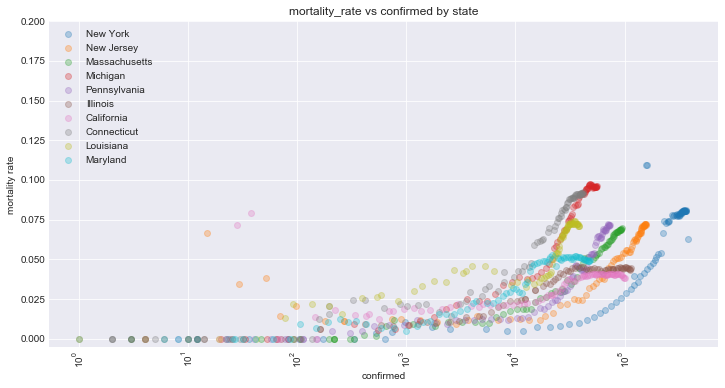

In [256]:
plot_mortality_rate_vs_infections(dfp_us_g, states, upper_lim=0.2, id_col='state', date_min=datetime.datetime(2020,3,1))

<a id='us_state_relative_increases'></a>
### Relative increases per day by state

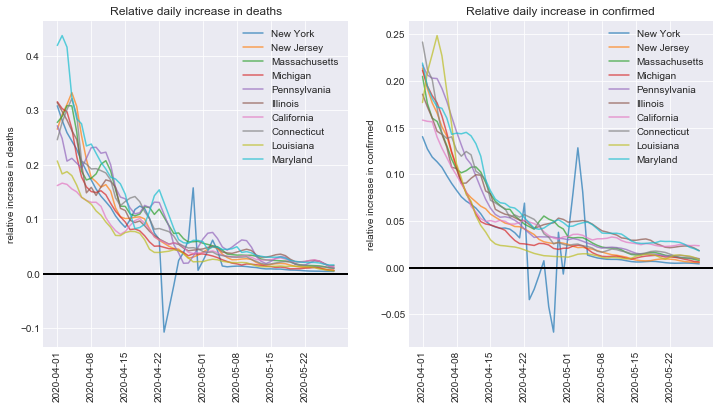

In [257]:
find_relative_increase_data_and_plot(dfp_us_g, n_locales=10, col_locale='state', dt=datetime.datetime(2020,4,1))


<a id='us_state_0_new'></a>
# When will each state hit 0 new deaths/confirmed? 

In [258]:
def fit_exp_new(dfp_country, 
            n_days_predict=14, 
            n_days_into_future=[1,7],
            col_locale='country', 
            top_countries=None, 
            n_countries=10, 
            date_most_recent=None,
            is_silent=False,
            fit_cols=['confirmed_new', 'deaths_new']
           ):
    
    # make predictions based on the last 2 weeks of data
    if date_most_recent is None:
        date_most_recent = dfp_country['date'].max()
    date_n_days_ago = date_most_recent - datetime.timedelta(days=n_days_predict-1)
    dfp_country_recent = (dfp_country[dfp_country['date'].between(date_n_days_ago, date_most_recent)].
                          sort_values(by=[col_locale, 'date'])
                         ).copy()

    # clean data for fit (convert to log)
    median_funcs = {}
    log_cols = []
    for col in fit_cols:
        log_col = f'{col}_log'
        dfp_country_recent[log_col] = dfp_country_recent[col].apply(lambda x: np.log10(x) if x > 1 else None)
        median_funcs[log_col] = np.nanmedian
        log_cols.append(log_col)
    dfp_country_recent['unixtime'] = dfp_country_recent['date'].apply(datetime_to_unixtime)
    
    # fill in the missing data with the median
    dfp_country_medians = dfp_country_recent.groupby(col_locale, as_index=False).agg(median_funcs).fillna(0)
    null_countries = list(dfp_country_recent[dfp_country_recent.isnull().any(axis=1)][col_locale].unique())
#     print(f"{col_locale}s with nulls: {','.join(null_countries)}")
#     display(dfp_country_medians.sample(n=5))
#     print(log_cols)
    for col in log_cols:
        for country in null_countries:
            val = dfp_country_medians[dfp_country_medians[col_locale] == country][col].values[0]
            #print(f"country={country}, median value={val:0.5f}")
            dfp_country_recent.loc[(dfp_country_recent[col_locale] == country) & (dfp_country_recent[col].isnull()), col] = val
    
    
    # make predictions to past, then future
    # add in future points
    dfp_country_recent_max_date = dfp_country_recent.groupby([col_locale], as_index=False).agg({'date': np.max})
    dfp_most_recent = dfp_country_recent.merge(dfp_country_recent_max_date, on=[col_locale, 'date'], how='inner').copy()
    list_dfp_recent = [dfp_country_recent]
    for n in n_days_into_future:
        dfp_most_recent_tmp = shift_future(dfp_most_recent, date_most_recent, n)
        list_dfp_recent.append(dfp_most_recent_tmp)
    dfp_country_recent = pd.concat(list_dfp_recent, axis=0, sort=False)
    
    for col in fit_cols:
        dfp_country_recent, dfp_country_deaths_fit = fit_poly1(dfp_country_recent, 
                                                               col_fit=f'{col}_log', 
                                                               col_pred=f'{col}_pred', 
                                                               col_locale=col_locale, 
                                                               date_most_recent=date_most_recent
                                                              )
    #dfp_country_recent['mortality_rate_pred'] = dfp_country_recent['deaths_pred'] / dfp_country_recent['confirmed_pred']

    # look only at the predictions for top countries
    if top_countries is None:
        top_countries = (dfp_most_recent.
                         sort_values(by='deaths', ascending=0).iloc[:n_countries][col_locale].values)
    dfp_forecasts = dfp_country_recent[(dfp_country_recent['date'] > date_most_recent)
                                       
                                      ].sort_values(by=[col_locale, 'date']).reset_index(drop=True)
    frac_cols = [col for col in dfp_forecasts.columns if 'frac_increase' in col]
    pred_cols = [col for col in dfp_forecasts.columns if '_pred' in col]
    id_cols = ['date', col_locale]
    dfp_forecasts_out = dfp_forecasts[id_cols + pred_cols + frac_cols].copy()
    dfp_forecasts_out['date'] = dfp_forecasts_out['date'].apply(lambda x: x.strftime('%Y-%m-%d'))

    # find the daily fractional increase in cases
    dfp_frac_increase = (dfp_forecasts_out.
                         groupby([col_locale]).
                         agg({x: np.mean for x in frac_cols}))
    dfp_frac_increase.columns = pd.MultiIndex.from_product([dfp_frac_increase.columns, ['']])

    # pivot so each date of prediction has its own column
    dfp_forecasts_print = dfp_forecasts_out.pivot(index=col_locale, 
                                                  columns='date', 
                                                  values=pred_cols  #'mortality_rate_pred'
                                                 ).sort_values(by=(pred_cols[0], dfp_forecasts_out['date'].min()), ascending=0)
    dfp_forecasts_print = dfp_forecasts_print.merge(dfp_frac_increase, on=col_locale, how='inner')
    if not is_silent:
        display(dfp_forecasts_print[dfp_forecasts_print.index.isin(top_countries)])
    return dfp_country_recent, dfp_forecasts_out


def plot_forecasts_new(dfp_country_recent, 
                   n_countries=10, 
                   n_columns=2, 
                   figsize=(12,24), 
                   date_min=datetime.datetime(2020, 2, 1),
                   col_locale='country',
                       top_countries=None,
                       cols_to_pred=['confirmed_new', 'deaths_new'],
                  ):
    # subset the top countries
    death_cols = [col for col in cols_to_pred if 'deaths' in col]
    dfp_non_pred = dfp_country_recent.dropna(subset=[death_cols[0]])
    dt_max = dfp_non_pred['date'].max()
    
    if top_countries is None:
        dfp_top_countries = (dfp_non_pred[dfp_non_pred['date'] == dt_max].
                             sort_values(by=death_cols[0], ascending=0).
                             iloc[:n_countries]
                            )
        top_countries = (dfp_top_countries.
                         iloc[:n_countries][col_locale].values
                        )
    dfp_country_recent = dfp_country_recent[dfp_country_recent[col_locale].isin(top_countries)]

    # plot the top countries
    i = 1
    n_rows = int(np.ceil(n_countries / n_columns))
    plt.figure(figsize=figsize)
    
    y_max = 1
    pred_cols = [x + '_pred' for x in cols_to_pred]
    for col in cols_to_pred:
        y_max = max(dfp_country_recent[col].max(), y_max)
    y_min = 1

    for country in top_countries:
        dfp_plot = dfp_country_recent[(dfp_country_recent[col_locale] == country) &
                               (dfp_country_recent['date'] >= date_min)
                              ].sort_values(by='date')
        
        # find total deaths
        dfp_plot_calcs = dfp_plot.dropna(subset={'deaths_new'})
        dfp_plot_latest = dfp_plot_calcs[dfp_plot_calcs['date'] == dfp_plot_calcs['date'].max()]
        x = 1 + dfp_plot_calcs['frac_increase_deaths'].mean()
        n_days = (dfp_country_recent['date'].max() - dfp_plot_calcs['date'].max()).days
        multiplier = (x**n_days - 1) / (x - 1)
        curr_deaths_new = dfp_plot_latest['deaths_new_pred'].values[0]
        curr_deaths_total = dfp_plot_latest['deaths'].values[0]
        n_deaths_pred = curr_deaths_new * multiplier + curr_deaths_total
        
        
        plt.subplot(n_rows, n_columns, i)
        for key in cols_to_pred:
            p = plt.plot(dfp_plot['date'], dfp_plot[key], alpha=0.5, linewidth=2, label=key)
            pred_col = f'{key}_pred'
            plt.plot(dfp_plot['date'], dfp_plot[pred_col], linestyle='--', linewidth=2, alpha=0.5, color=p[0].get_color(), label=pred_col)
        plt.legend(loc='best')
        plt.ylabel('num cases')
        plt.title(f'{col_locale}: {country}, pred_tot_deaths = {n_deaths_pred:0.0f}, curr_deaths = {curr_deaths_total:0.0f}, x={x:0.3f}')
        plt.yscale('log')
        plt.ylim([y_min, y_max])
        plt.xticks(rotation=90)

        i += 1
    plt.tight_layout()
    plt.show()
    return None
                       
                       
def save_forecast_new(dfp_forecasts_out, dfp_country_recent, col_locale='state', n_days_training=14):
    date_most_recent = dfp_country_recent.dropna(subset=['deaths'])['date'].max()
    dfp_forecasts_out['date_of_forecast'] = date_most_recent
    save_name = f"new_cases_covid-19_{col_locale}_forecast_from_{date_most_recent.strftime('%Y-%m-%d')}_n_days_training={n_days_training}.csv"
    save_path = os.path.join('predictions', save_name)
    dfp_forecasts_out.to_csv(save_path, index=False)
    print(f'saved forecast to {save_path}')
    return None

In [259]:
n_days_training = 21
dfp_us_recent_1, dfp_forecasts_us_out_1 = fit_exp_new(dfp_us_g, 
                                                    n_days_predict=n_days_training,
                                                    n_days_into_future=[1,7,2*7,4*7,8*7,12*7,16*7,20*7,24*7,32*7], 
                                                    col_locale='state', 
                                                    top_countries=None
                                                   )

confirmed_new_pred                                              \
date                  2020-05-29 2020-06-04 2020-06-11 2020-06-25 2020-07-23   
state                                                                          
California                  2196       2399       2660       3269       4940   
Illinois                    1683       1498       1308        997        579   
New York                    1184        928        698        395        127   
Maryland                     809        748        682        568        393   
New Jersey                   759        618        486        301        115   
Pennsylvania                 623        527        433        293        134   
Massachusetts                617        477        353        193         58   
Louisiana                    430        481        549        714       1208   
Connecticut                  398        356        312        241        143   
Michigan                     358        312        265        192        101   

                                                                      \
date          2020-08-20 2020-09-17 2020-10-15 2020-11-12 2021-01-07   
state                                                                  
California          7463      11274      17032      25731      58727   
Illinois             336        195        113         65         22   
New York              40         13          4          1          0   
Maryland             272        188        130         90         43   
New Jersey            44         16          6          2          0   
Pennsylvania          61         28         12          5          1   
Massachusetts         17          5          1          0          0   
Louisiana           2044       3459       5852       9901      28344   
Connecticut           84         50         29         17          6   
Michigan              53         28         14          7          2   

              deaths_new_pred                                              \
date               2020-05-29 2020-06-04 2020-06-11 2020-06-25 2020-07-23   
state                                                                       
California                 45         38         32         22         10   
Illinois                   65         55         45         30         14   
New York                   99         79         60         35         12   
Maryland                   34         30         25         19         10   
New Jersey                 54         36         22          9          1   
Pennsylvania               38         28         20         10          2   
Massachusetts              58         45         33         18          5   
Louisiana                  21         18         16         12          7   
Connecticut                31         25         20         12          4   
Michigan                   22         17         11          5          1   

                                                                      \
date          2020-08-20 2020-09-17 2020-10-15 2020-11-12 2021-01-07   
state                                                                  
California             5          2          1          0          0   
Illinois               6          2          1          0          0   
New York               4          1          0          0          0   
Maryland               5          3          1          0          0   
New Jersey             0          0          0          0          0   
Pennsylvania           0          0          0          0          0   
Massachusetts          1          0          0          0          0   
Louisiana              4          2          1          0          0   
Connecticut            1          0          0          0          0   
Michigan               0          0          0          0          0   

              frac_increase_confirmed frac_increase_deaths  
date                                

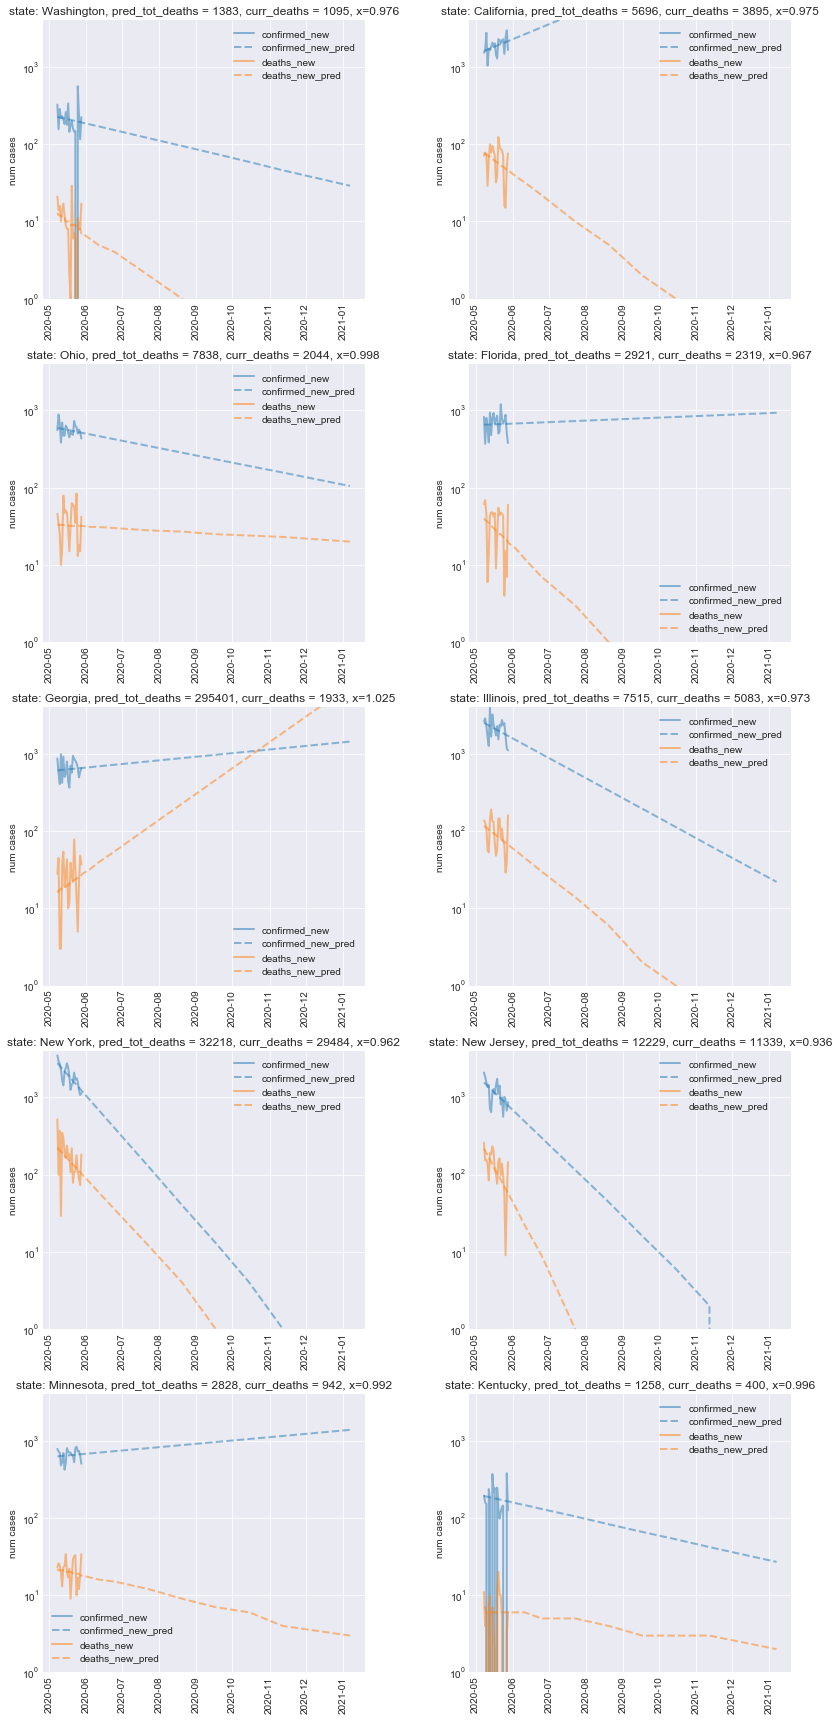

In [260]:
plot_forecasts_new(dfp_us_recent_1, col_locale='state', top_countries=['Washington', 'California', 'Ohio', 'Florida', 'Georgia', 'Illinois', 'New York', 'New Jersey', 'Minnesota', 'Kentucky'])

In [261]:
save_forecast_new(dfp_forecasts_us_out_1, dfp_us_recent_1, 'state', n_days_training=n_days_training)

saved forecast to predictions/new_cases_covid-19_state_forecast_from_2020-05-28_n_days_training=21.csv


### All states sorted by new deaths DESC

In [262]:
dfp_us_frac_new_increase = (dfp_us_recent_1[['state', 'frac_increase_deaths', 'frac_increase_confirmed']].
                             drop_duplicates().
                             sort_values(by='frac_increase_deaths', ascending=0).
                             reset_index(drop=True)
                            )
dfp_us_frac_new_increase

state  frac_increase_deaths  frac_increase_confirmed
0               Rhode Island              0.028540                -0.022120
1                    Georgia              0.025432                 0.003527
2                       Iowa              0.023052                -0.008252
3                Mississippi              0.009330                 0.008826
4                   Nebraska              0.007961                -0.007246
5                     Nevada              0.006958                -0.000297
6                   Virginia              0.003466                 0.003394
7               North Dakota              0.002704                 0.004081
8                    Montana              0.000000                 0.003085
9             Virgin Islands              0.000000                 0.000000
10                   Vermont              0.000000                -0.004668
11                 Recovered              0.000000                 0.000000
12  Northern Mariana Islands              0.000000                -0.001316
13                    Alaska              0.000000                 0.001289
14                   Wyoming              0.000000                 0.005532
15                      Guam              0.000000                 0.013421
16                    Hawaii              0.000000                 0.001759
17          Diamond Princess              0.000000                 0.000000
18            Grand Princess              0.000000                 0.000000
19                      Utah             -0.000625                -0.006714
20                     Maine             -0.001578                 0.001657
21                  Arkansas             -0.001957                 0.031232
22                      Ohio             -0.001979                -0.007052
23              South Dakota             -0.002542                -0.041314
24                  Colorado             -0.004360                -0.033700
25                  Kentucky             -0.004374                -0.008001
26                  Oklahoma             -0.004643                -0.006755
27             West Virginia             -0.006282                 0.037925
28               Puerto Rico             -0.006748                 0.029259
29            South Carolina             -0.006753                 0.006928
30                 Tennessee             -0.006785                 0.020585
31                     Idaho             -0.007868                 0.027886
32                 Minnesota             -0.007943                 0.003244
33                 Wisconsin             -0.011214                 0.020605
34                    Oregon             -0.012977                -0.053101
35             New Hampshire             -0.013341                -0.023204
36                New Mexico             -0.016946                -0.007377
37                 Louisiana             -0.019575                 0.018958
38                  Maryland             -0.021600                -0.013024
39                    Kansas             -0.022253                -0.054258
40                Washington             -0.024228                -0.008361
41                California             -0.025461                 0.014844
42      District of Columbia             -0.025856                -0.028540
43                  Illinois             -0.027494                -0.019213
44                   Arizona             -0.028103                -0.002571
45                  Delaware             -0.031121                -0.031243
46                   Alabama             -0.033016                 0.027331
47                   Florida             -0.033203                 0.001466
48            North Carolina             -0.033436                 0.007329
49                   Indiana             -0.034050                -0.016217
50               Connecticut             -0.035180                -0.018450
51                  New York             -0.037668                -0.03

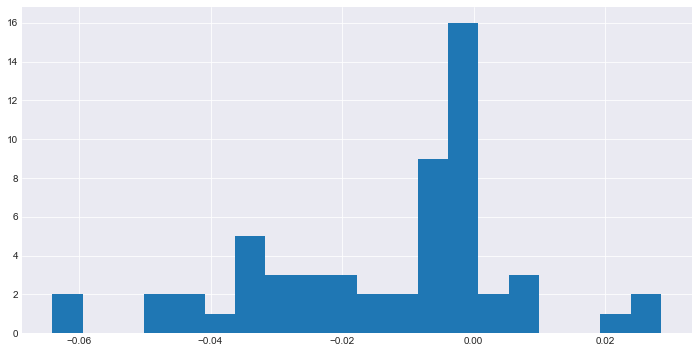

In [263]:
dfp_us_frac_new_increase.frac_increase_deaths.hist(bins=20)

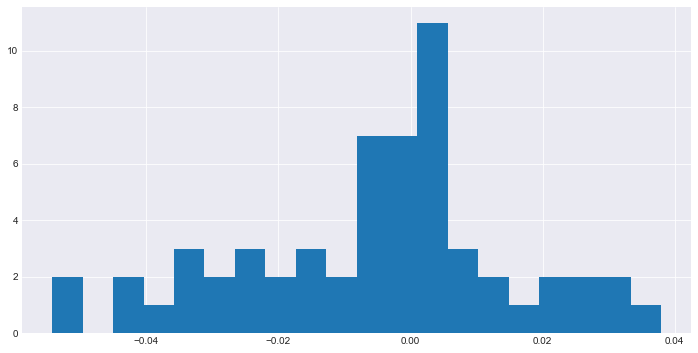

In [264]:
dfp_us_frac_new_increase.frac_increase_confirmed.hist(bins=20)

### Which states are increasing in new deaths <u>most</u> quickly?

In [265]:
dfp_us_frac_new_increase = (dfp_us_recent_1[['state', 'frac_increase_deaths', 'frac_increase_confirmed']].
                             drop_duplicates().
                             sort_values(by='frac_increase_deaths', ascending=0).
                             reset_index(drop=True)
                            )
dfp_us_frac_new_increase.head(10)

state  frac_increase_deaths  frac_increase_confirmed
0    Rhode Island              0.028540                -0.022120
1         Georgia              0.025432                 0.003527
2            Iowa              0.023052                -0.008252
3     Mississippi              0.009330                 0.008826
4        Nebraska              0.007961                -0.007246
5          Nevada              0.006958                -0.000297
6        Virginia              0.003466                 0.003394
7    North Dakota              0.002704                 0.004081
8         Montana              0.000000                 0.003085
9  Virgin Islands              0.000000                 0.000000

### Which states are increasing in new deaths <u>least</u> quickly?

In [266]:
dfp_us_frac_new_increase.tail(10)

state  frac_increase_deaths  frac_increase_confirmed
48  North Carolina             -0.033436                 0.007329
49         Indiana             -0.034050                -0.016217
50     Connecticut             -0.035180                -0.018450
51        New York             -0.037668                -0.039790
52   Massachusetts             -0.041319                -0.042072
53           Texas             -0.045441                -0.014572
54    Pennsylvania             -0.045982                -0.027501
55        Michigan             -0.048733                -0.022656
56        Missouri             -0.061949                 0.005566
57      New Jersey             -0.064065                -0.033673

### Is there a day-of-the-week effect on new deaths?

In [267]:
dfp_us_recent_1['dow'] = dfp_us_recent_1['date'].apply(lambda x: x.weekday())
dfp_us_dow = dfp_us_recent_1.dropna(subset={'deaths_new'}).copy()

In [268]:
dfp_us_dow['death_delta'] = dfp_us_dow['deaths_new']- dfp_us_dow['deaths_new_pred']
dfp_us_dow['death_rel_delta'] = (dfp_us_dow['death_delta']) / dfp_us_dow['deaths_new_pred']

dfp_us_dow['confirmed_delta'] = dfp_us_dow['confirmed_new']- dfp_us_dow['confirmed_new_pred']
dfp_us_dow['confirmed_rel_delta'] = dfp_us_dow['confirmed_delta'] / dfp_us_dow['confirmed_new_pred']
dfp_us_dow_deltas = (dfp_us_dow.groupby(['state', 'dow'], as_index=False).
                     agg({'death_delta': np.mean, 
                          'death_rel_delta': np.median, 
                          'deaths_new': np.mean, 
                          'deaths_new_pred': np.mean, 
                          'confirmed_delta': np.mean, 
                          'confirmed_rel_delta': np.median})
                    )

In [269]:
dfp_us_dow_deltas[dfp_us_dow_deltas.state == 'Washington']

state  dow  death_delta  death_rel_delta  deaths_new  \
378  Washington    0    -2.333333        -0.166667    7.666667   
379  Washington    1    -1.333333         0.125000    8.000000   
380  Washington    2     8.666667         0.545455   18.000000   
381  Washington    3     2.666667         0.090909   11.666667   
382  Washington    4     1.666667        -0.100000   12.333333   
383  Washington    5    -1.000000        -0.200000    9.333333   
384  Washington    6    -2.000000        -0.200000    8.000000   

     deaths_new_pred  confirmed_delta  confirmed_rel_delta  
378        10.000000        99.000000            -0.022523  
379         9.333333         8.000000             0.050000  
380         9.333333       -31.000000            -0.045872  
381         9.000000       -15.000000            -0.157407  
382        10.666667        30.000000             0.219626  
383        10.333333       -51.333333            -0.260000  
384        10.000000        -3.333333             0.282511

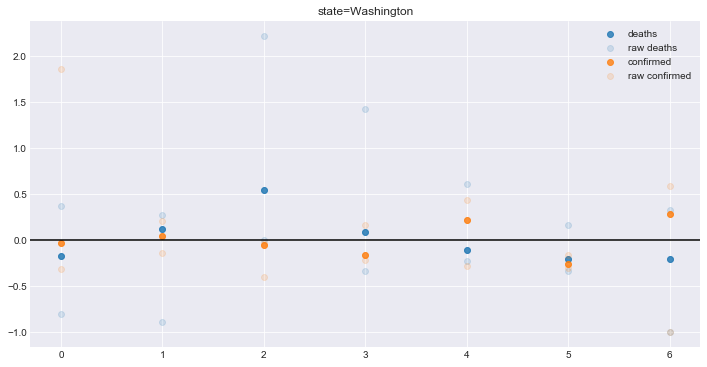

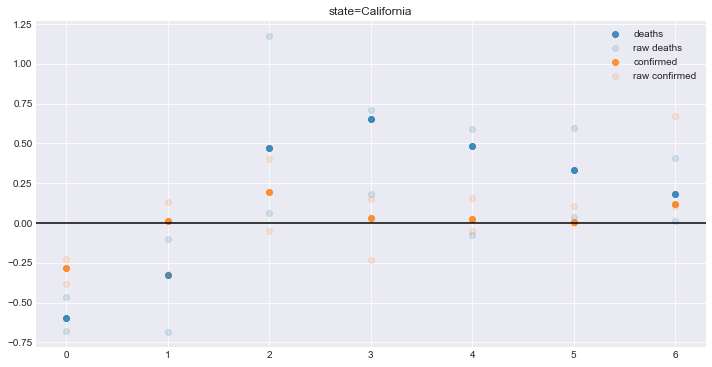

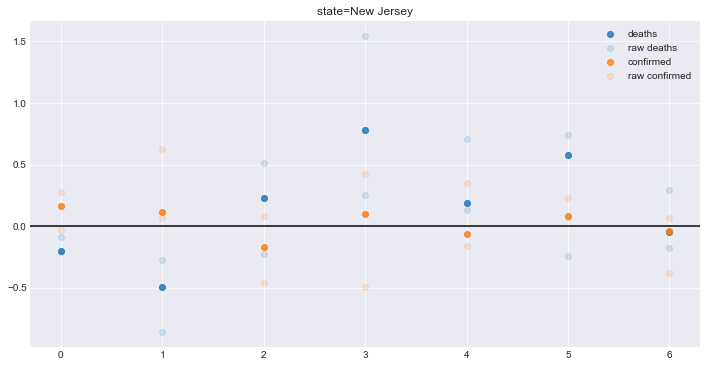

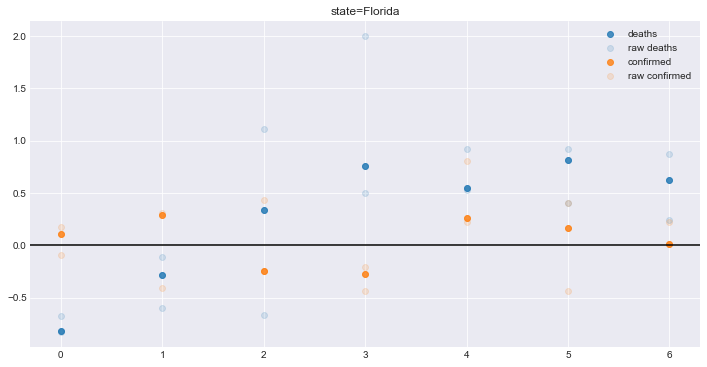

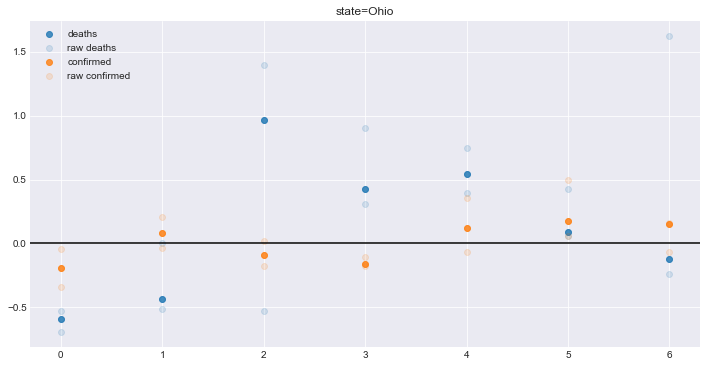

In [270]:
alpha_soft = 0.15
alpha_hard = 0.8
for state in ['Washington', 'California', 'New Jersey', 'Florida', 'Ohio']:
    dfp_plot = dfp_us_dow_deltas[(dfp_us_dow_deltas.state == state)]  #(dfp_us_dow_deltas.deaths_new >= 10) & 
    dfp_plot_raw = dfp_us_dow[dfp_us_dow.state == state]
    
    p = plt.plot(dfp_plot['dow'], dfp_plot['death_rel_delta'], 'o', alpha=alpha_hard, label='deaths')
    color = p[0].get_color()
    plt.plot(dfp_plot_raw['dow'], dfp_plot_raw['death_rel_delta'], 'o', alpha=alpha_soft, label='raw deaths', color=color)
    
    q = plt.plot(dfp_plot['dow'], dfp_plot['confirmed_rel_delta'], 'o', alpha=alpha_hard, label='confirmed')
    color = q[0].get_color()
    plt.plot(dfp_plot_raw['dow'], dfp_plot_raw['confirmed_rel_delta'], 'o', alpha=alpha_soft, label='raw confirmed', color=color)
    
    plt.legend(loc='best')
    plt.axhline(0, color='k')
    plt.title(f'state={state}')

    #plt.ylim([-0.5,0.5])
    #plt.ylim([-2,2])
    plt.show()